# UMAP + HDBSCAN + FAISS

In [131]:

!pip install faiss-cpu    # (Linux/macOS)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 23.7 MB/s eta 0:00:00


In [1]:
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
from umap import UMAP

warnings.filterwarnings("ignore", category=FutureWarning)


In [8]:
# lectura del conjunto de datos
#df = pd.read_csv('datos/df_final.csv', header=1)
df = pd.read_csv('/content/df_final.csv')

In [9]:
print(df.columns)

Index(['GLU_PRIMERA/FIRST_URG/EMERG', 'SAT_02_ULTIMA/LAST_URG/EMERG',
       'GLU_ULTIMA/LAST_URG/EMERG', 'EDAD/AGE', 'TA_MAX_ULTIMA/LAST_URGEMERG',
       'FC/HR_ULTIMA/LAST_URG/EMERG', 'PATIENT ID',
       'TA_MAX_PRIMERA/FIRST/EMERG_URG', 'UCI_DIAS/ICU_DAYS',
       'FC/HR_PRIMERA/FIRST_URG/EMERG',
       ...
       'PROC_05_DS6', 'PROC_10', 'DIA_05_DS6', 'DIA_07_DS6', 'POAD_04',
       'DIA_03_DS6', 'POAD_06', 'NEO_01', 'PROC_13', 'DIA_11_DS6'],
      dtype='object', length=132)


In [10]:
# filtrar dataframe por pacientes con COVID19
df_covid = df[df['DIAG ING/INPAT'].str.contains('COVID19', na=False, case=False)]
print("Primeras filas del dataframe filtrado por COVID19:")
print(df_covid.head())

Primeras filas del dataframe filtrado por COVID19:
   GLU_PRIMERA/FIRST_URG/EMERG  SAT_02_ULTIMA/LAST_URG/EMERG  \
0                          0.0                           0.0   
1                          0.0                          97.0   
2                          0.0                          95.0   
3                          0.0                          93.0   
4                          0.0                          99.0   

   GLU_ULTIMA/LAST_URG/EMERG  EDAD/AGE  TA_MAX_ULTIMA/LAST_URGEMERG  \
0                        0.0      75.0                          0.0   
1                        0.0      62.0                        160.0   
2                        0.0      69.0                        141.0   
3                        0.0      67.0                        151.0   
4                        0.0      72.0                        146.0   

   FC/HR_ULTIMA/LAST_URG/EMERG  PATIENT ID  TA_MAX_PRIMERA/FIRST/EMERG_URG  \
0                          0.0        44.0                 

In [11]:
df_covid.describe()

GLU_PRIMERA/FIRST_URG/EMERG  SAT_02_ULTIMA/LAST_URG/EMERG  \
count                  3270.000000                   3270.000000   
mean                      2.051376                     78.883486   
std                      21.478933                     33.227649   
min                       0.000000                      0.000000   
25%                       0.000000                     87.000000   
50%                       0.000000                     93.000000   
75%                       0.000000                     96.000000   
max                     448.000000                     99.000000   

       GLU_ULTIMA/LAST_URG/EMERG     EDAD/AGE  TA_MAX_ULTIMA/LAST_URGEMERG  \
count                3270.000000  3270.000000                  3270.000000   
mean                    2.410092    66.979817                    92.962997   
std                    23.146765    16.525171                    62.953445   
min                     0.000000     0.000000                     0.000000   
25%                     0.000000    56.000000                     0.000000   
50%                     0.000000    68.000000                   120.000000   
75%                     0.000000    79.000000                   140.000000   
max                   448.000000   106.000000                   220.000000   

       FC/HR_ULTIMA/LAST_URG/EMERG   PATIENT ID  \
count                  3270.000000  3270.000000   
mean                     76.327829  1825.310398   
std                      36.705422  1169.865190   
min                       0.000000     1.000000   
25%                      70.000000   876.250000   
50%                      85.000000  1698.500000   
75%                     100.000000  2534.750000   
max                     190.000000  4475.000000   

       TA_MAX_PRIMERA/FIRST/EMERG_URG  UCI_DIAS/ICU_DAYS  \
count                     3270.000000        3270.000000   
mean                        88.215596           7.528012   
std                         64.679380           6.498916   
min                          0.000000           0.000000   
25%                          0.000000           3.200000   
50%                        118.000000           6.400000   
75%                        139.000000          10.000000   
max                        220.000000          87.000000   

       FC/HR_PRIMERA/FIRST_URG/EMERG  TA_MIN_ULTIMA/LAST_URG/EMERG  \
count                    3270.000000                   3270.000000   
mean                       72.238838                     53.840061   
std                        39.257963                     41.261780   
min                         0.000000                      0.000000   
25%                        65.000000                      0.000000   
50%                        85.000000                     70.000000   
75%                        99.000000                     80.000000   
max                       190.000000                    845.000000   

       SAT_02_PRIMERA/FIRST_URG/EMERG  TA_MIN_PRIMERA/FIRST_URG/EMERG  \
count                     3270.000000                      3270.00000   
mean                        74.785321                        51.43578   
std                         36.892489                        45.33977   
min                          0.000000                         0.00000   
25%                         84.000000                         0.00000   
50%                         93.000000                        67.50000   
75%                         96.000000                        80.00000   
max                         99.000000                       845.00000   

       DOSIS_MEDIA_DIARIA/DAILY_AVRG_DOSE  FC/HR_ING/INPAT  TA_MIN_ING/INPAT  \
count                         3270.000000      3270.000000       3270.000000   
mean                             2.434251        57.109786         36.516208   
std                              2.409917        36.655246         37.005918   
min                              1.000000         0.000000          0.000000   
2

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Columns: 132 entries, GLU_PRIMERA/FIRST_URG/EMERG to DIA_11_DS6
dtypes: float64(20), object(112)
memory usage: 3.9+ MB


Para realizar el clustering, se necesitan decodificar los diagnosticos, por este motivo se realizan los siguientes preprocesamientos:

In [14]:
# filtrar columnas que empiezan por DIA_
df_covid_dia = df_covid.filter(regex='^DIA_')
# Mostrar las primeras filas del dataframe filtrado por DIA_
print("Primeras filas del dataframe filtrado por DIA_:")
print(df_covid_dia.head())

Primeras filas del dataframe filtrado por DIA_:
  DIA_10_DS5 DIA_09_DS5 DIA_05_DS5 DIA_07_DS5 DIA_PPAL_DS5 DIA_02_DS5  \
0      J44.0    Z20.828     R68.89     R68.89      Z20.828      J98.8   
1      J44.0    Z20.828     R68.89     R68.89        R91.8     R68.89   
2      J44.0    Z20.828     R68.89     R68.89       C79.10      G89.3   
3      J44.0    Z20.828     R68.89     R68.89       I26.99      I50.9   
4      J44.0    Z20.828     R68.89     R68.89     T45.1X5A      R50.2   

  DIA_12_DS5 DIA_03_DS5 DIA_08_DS5 DIA_06_DS5  ...   DIA_13 DIA_15 DIA_02_DS6  \
0     9690/3      J18.9     B97.29     B97.29  ...  L89.311  D64.9    I97.410   
1     9690/3      J18.9     B97.29     B97.29  ...   M19.90  E55.9     J12.89   
2     9690/3      J18.9     B97.29     B97.29  ...    J43.2  Z96.0      R00.1   
3     9690/3      J18.9     B97.29     B97.29  ...      Y95  G72.0     C78.02   
4     9690/3     C81.90     B97.29     B97.29  ...    E11.9  I25.2     B37.81   

   DIA_18 DIA_08_DS6   DIA

In [15]:
# crear columna que combina todos los valores de las columnas DIA_ y los separa por coma
df_covid_dia.loc[:, 'COMORBILIDADES/COMORBILITIES'] = df_covid_dia.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
# unir la columna al dataframe original df_covid
df_covid = df_covid.join(df_covid_dia['COMORBILIDADES/COMORBILITIES'])
df_covid['COMORBILIDADES/COMORBILITIES'].value_counts().head(10)

<ipython-input-15-5759a5fb3827>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_dia.loc[:, 'COMORBILIDADES/COMORBILITIES'] = df_covid_dia.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)


COMORBILIDADES/COMORBILITIES
J44.0, Z20.828, R68.89, R68.89, J18.9, R68.89, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82     12
J44.0, Z20.828, R68.89, R68.89, U07.1, J12.89, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, U07.1, Z79.82, I10, Z79.82, Z79.82, J12.89, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82       9
J44.0, Z20.828, R68.89, R68.89, J12.89, U07.1, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, U07.1, Z79.82, I10, Z79.82, Z79.82, J12.89, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82       7
J44.0, Z20.828, R68.89, R68.89, R68.89, J18.9, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82      7
J44.0, Z20.828, R68.89, R68.89, J12.89, B97.29, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82     6
J44.0, Z20.828, R68.89, R68.89, B34.2, R68.89, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82      5
J44.0, Z20.828, R68.89, R68.89, J18.9, R68.89, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J18.9, Z79.82, I10, Z79.82, Z79.82, R68.89, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82       5
J44.0, Z20.828, R68.89, R68.89, B97.29, J98.8, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82      5
J44.0, Z20.828, R68.89, R68.89, J12.89, J18.9, 9690/3, B97.29, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, J96.00, Z79.82     4
J44.0, Z20.828, R68.89, R68.89, B34.2, R68.89, 9690/3, J18.9, B97.29, B97.29, R68.89, B97.29, Z87.891, Z87.891, Z79.01, Z79.82, I10, Z59.3, J12.89, Z79.82, I10, Z79.82, Z79.82, B97.29, Z79.82, E78.5, Z79.82, I10, I10, I10, Z79.82         3
Name: count, dtype: int64

In [16]:
# Una vez verifiques los nombres, selecciona las columnas correctas:
columnas = ['PATIENT ID', 'EDAD/AGE', 'SEXO/SEX', 'DIAG ING/INPAT',
                'FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', 'UCI_DIAS/ICU_DAYS',
                'TEMP_ING/INPAT', 'SAT_02_ING/INPAT', 'RESULTADO/VAL_RESULT',
                'MOTIVO_ALTA/DESTINY_DISCHARGE_ING', 'COMORBILIDADES/COMORBILITIES']

df_covid = df_covid[columnas]
# Rellenar los valores nulos con 0
df_covid.fillna(0, inplace=True)
# Convertir las columnas numéricas a tipo float
# Convertir las columnas a numéricas, forzando errores a NaN y luego rellenando con 0 antes de convertir a int/float
df_covid['EDAD/AGE'] = pd.to_numeric(df_covid['EDAD/AGE'], errors='coerce').fillna(0).astype(int)
df_covid['PATIENT ID'] = pd.to_numeric(df_covid['PATIENT ID'], errors='coerce').fillna(0).astype(int)
df_covid['UCI_DIAS/ICU_DAYS'] = pd.to_numeric(df_covid['UCI_DIAS/ICU_DAYS'], errors='coerce').fillna(0).astype(int)
df_covid['TEMP_ING/INPAT'] = pd.to_numeric(df_covid['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(float)
df_covid['SAT_02_ING/INPAT'] = pd.to_numeric(df_covid['SAT_02_ING/INPAT'], errors='coerce').fillna(0).astype(int)
# imputar los valores 0 por la media de la columna
df_covid['UCI_DIAS/ICU_DAYS'] = df_covid['UCI_DIAS/ICU_DAYS'].replace(0, round(df_covid['UCI_DIAS/ICU_DAYS'].mean()))
df_covid['EDAD/AGE'] = df_covid['EDAD/AGE'].replace(0, round((df_covid['EDAD/AGE'].mean())))
df_covid['TEMP_ING/INPAT'] = df_covid['TEMP_ING/INPAT'].replace(0, round(df_covid['TEMP_ING/INPAT'].mean()))
df_covid['PATIENT ID'] = df_covid['PATIENT ID'].replace(0, round(df_covid['PATIENT ID'].mean()))
df_covid['SAT_02_ING/INPAT'] = df_covid['SAT_02_ING/INPAT'].replace(0, round(df_covid['SAT_02_ING/INPAT'].mean()))
# en MOTIVO_ALTA/DESTINY_DISCHARGE_ING sustituir los valores nulos por 'Domicilio'
df_covid['MOTIVO_ALTA/DESTINY_DISCHARGE_ING'] = df_covid['MOTIVO_ALTA/DESTINY_DISCHARGE_ING'].fillna('Domicilio')


Codificación CEI-10 de comorbilidades asociadas a COVID-19

Traducciones de Enfermedades al Inglés
Hipertensión arterial → Arterial hypertension / High blood pressure

Diabetes → Diabetes

Enfermedad cardiovascular → Cardiovascular disease

Enfermedad renal crónica → Chronic kidney disease

Enfermedad respiratoria crónica → Chronic respiratory disease

Obesidad → Obesity

Cáncer → Cancer

Inmunodeficiencia → Immunodeficiency

Enfermedad hepática → Liver disease

VIH/SIDA → HIV/AIDS

Tuberculosis activa → Active tuberculosis

Trastornos neurológicos → Neurological disorders

Trastornos de células falciformes → Sickle cell disorders

Tabaquismo → Smoking / Tobacco use disorder

In [17]:
dict_diagnosticos = {
    "HIPER_ART/ART_HYPER": ["G93.2", "I10", "I10.0", "I11.9", "I12.0", "I12.9", "I13.0", "I13.10", "I13.2", "I16.0", "I16.9", "I27.2", "I27.20", "I67.4", "K76.6"],
    "DIABETES/DIABETES": ["E09", "E09.649", "E09.65", "E09.9", "E10", "E10.319", "E10.65", "E10.9", "E11", "E11.22", "E11.40", "E11.42", "E11.51", "E11.59", "E11.621", "E11.649", "E11.65", "E11.9", "O24", "O24.410", "Z83.2", "Z86.32"],
    "ENF_CARDIO/CARDIO_DISEASE": ["I13.0", "I13.10", "I13.2", "I21.02", "I21.9", "I24.9", "I25.2", "I25.89", "I25.9", "I31.3", "I42.0", "I42.1", "I42.2", "I42.8", "I42.9", "I43", "I51.7", "R57.0"],
    "ENF_RENAL/KIDNEY_DISEASE": ["R39.2", "Q60.3", "N25.81", "N19", "N18.9", "N18.5", "N18.4", "N18.3", "N18.2", "N18.1", "N17.9", "N17.0", "I72.2", "I12.9", "I12.0", "E27.9", "E11.22", "D63.1"],
    "ENF_RESPIRA/RESPI_DISEASE": ["B09.9", "J06.9", "J68.4", "J80", "J95.821", "J96", "J96.0", "J96.00", "J96.01", "J96.02", "J96.1", "J96.10", "J96.2", "J96.20", "J96.21", "J96.22", "J96.9", "J96.90", "J96.91", "J96.92", "J98.8"],
    "OBESITIDAD/OBESITY": ["E66.01", "E66.2", "E66.8", "E66.9"],
    "CANCER/CANCER": ["C03.0", "C15.9", "C16.0", "C16.9", "C18.1", "C18.4", "C18.7", "C18.9", "C19", "C20", "C21.10", "C22.0", "C22.1", "C24.0", "C25.0", "C25.9", "C34", "C34.01", "C34.11", "C34.12", "C34.21", "C34.32", "C34.90", "C34.91", "C43.72", "C43.9", "C45", "C45.0", "C50", "C50.211", "C50.911", "C50.912", "C50.919", "C50.929", "C61", "C64.1", "C64.2", "C67.9", "C71.2", "C76.3", "C77.1", "C77.2", "C77.8", "C77.9", "C78.00", "C78.01", "C78.02", "C78.2", "C78.4", "C78.6", "C78.7", "C79.02", "C79.31", "C79.51", "C79.52", "C79.71", "C79.89", "C7A.00", "C7A.1", "C7B.01", "C7B.02", "C7B.03", "C77B.09", "C7B.8", "C80.0", "C81.90", "C82.09", "C82.10", "C82.40", "C82.90", "C82.99", "C83.03", "C83.09", "C83.31", "C83.39", "C83.28", "C85.90", "D12.5", "D12.6", "D13.4", "D16.01", "D16.5", "D17.23", "D17.71", "D17.79", "D18.02", "D18.03", "D18.09", "D32.0", "D32.9", "D33.3", "D35.01", "D38.1", "8000/3", "8010/3", "8140/3", "8070/3", "9590/3"],
    "INMUNO/IMMUNO": ["D80.3", "D81.89", "D83.9", "Z87.72"],
    "ENF_HEPATICA/LIVER_DISEASE": ["B19.10", "B19.20", "C22.1", "K70.30", "K70.31", "K70.40", "K70.9", "K71.10", "K71.8", "K71.9", "K72.00", "K72.90", "K74.5", "K74.60"],
    "VIH/SIDA": ["B20"],
    "TUBERCULOSIS/TUBERCULOSIS": ["A15.0", "B90.9", "Z86.11"],
    "TRAST_NEURO/NEURO_DISORDERS": ["G21.0", "I69.198", "I69.398", "I69.818"],
    "TRAST_CEL_FALCI/SICKLE_CELL_DIS": ["D57.0", "D57.1", "D57.2", "D57.3", "D57.4", "D57.8", "D57.9"],
    "TABAQUISMO/SMOKING": ["F17.200", "F17.201", "F17.203", "F17.204", "F17.205", "F17.206", "F17.207", "F17.208", "F17.209", "F17.210", "F17.211", "F17.212", "F17.213", "F17.214", "F17.215", "F17.216", "F17.217", "F17.218", "F17.219", "O99.335"]
}

In [18]:
for tipo, codigos in dict_diagnosticos.items():
    df_covid.loc[:, tipo] = df_covid['COMORBILIDADES/COMORBILITIES'].apply(lambda x: 1 if any(codigo in str(x) for codigo in codigos) else 0)


# Análisis de clústeres de Ingresados por COVID-19 y comorbilidades

In [19]:
# eliminar columnas FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME, TEMP_ING/INPAT, SAT_02_ING/INPAT
df_comorbilidades = df_covid.drop(columns=['FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', 'TEMP_ING/INPAT', 'SAT_02_ING/INPAT', 'RESULTADO/VAL_RESULT', 'MOTIVO_ALTA/DESTINY_DISCHARGE_ING', 'DIAG ING/INPAT', 'COMORBILIDADES/COMORBILITIES'])
df_comorbilidades.head(5)

PATIENT ID  EDAD/AGE SEXO/SEX  UCI_DIAS/ICU_DAYS  HIPER_ART/ART_HYPER  \
0          44        75   FEMALE                  1                    0   
1         585        62   FEMALE                 10                    0   
2         587        69     MALE                 13                    0   
3         586        67   FEMALE                 13                    1   
4         588        72     MALE                  8                    1   

   DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  ENF_RENAL/KIDNEY_DISEASE  \
0                  0                          0                         0   
1                  0                          0                         0   
2                  0                          0                         0   
3                  0                          0                         0   
4                  1                          1                         0   

   ENF_RESPIRA/RESPI_DISEASE  OBESITIDAD/OBESITY  CANCER/CANCER  \
0                          1                   0              0   
1                          0                   0              0   
2                          0                   0              1   
3                          1                   0              1   
4                          0                   0              1   

   INMUNO/IMMUNO  ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  \
0              0                           0         0   
1              0                           1         0   
2              0                           0         0   
3              0                           0         0   
4              0                           0         0   

   TUBERCULOSIS/TUBERCULOSIS  TRAST_NEURO/NEURO_DISORDERS  \
0                          0                            0   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          0                            0   

   TRAST_CEL_FALCI/SICKLE_CELL_DIS  TABAQUISMO/SMOKING  
0                                0                   0  
1                                0                   1  
2                                0                   0  
3                                0                   0  
4                                0                   0

In [20]:
# binarizar columna SEXO/SEX FEMALE = 0 , MALE = 1
df_comorbilidades['SEXO/SEX'] = df_comorbilidades['SEXO/SEX'].map({'FEMALE': 0, 'MALE': 1})


In [21]:
# cambiar formato de la columna EDAD/AGE a int
df_comorbilidades['EDAD/AGE'] = df_comorbilidades['EDAD/AGE'].astype(int)
# cambiar formato de la columna SEXO/AGE a int
df_comorbilidades['SEXO/SEX'] = df_comorbilidades['SEXO/SEX'].astype(int)

In [22]:
# se susituyen los valores NaN de la columna UCI_DIAS/ICU_DAYS por la media de la columna
df_comorbilidades.fillna({'UCI_DIAS/ICU_DAYS': df_comorbilidades['UCI_DIAS/ICU_DAYS'].mean()}, inplace=True)
# se transforma la columna UCI_DIAS/ICU_DAYS a int
df_comorbilidades['UCI_DIAS/ICU_DAYS'] = df_comorbilidades['UCI_DIAS/ICU_DAYS'].astype(int)


In [23]:
# normalizar la columna EDAD/AGE
scaler = MinMaxScaler()
df_comorbilidades_encoded = df_comorbilidades.copy()
# normalizar el dataset
df_comorbilidades_encoded = pd.DataFrame(scaler.fit_transform(df_comorbilidades_encoded), columns=df_comorbilidades_encoded.columns)
df_comorbilidades_encoded

PATIENT ID  EDAD/AGE  SEXO/SEX  UCI_DIAS/ICU_DAYS  HIPER_ART/ART_HYPER  \
0       0.009611  0.704762       0.0           0.000000                  0.0   
1       0.130532  0.580952       0.0           0.104651                  0.0   
2       0.130979  0.647619       1.0           0.139535                  0.0   
3       0.130755  0.628571       0.0           0.139535                  1.0   
4       0.131203  0.676190       1.0           0.081395                  1.0   
...          ...       ...       ...                ...                  ...   
3265    0.611757  0.419048       1.0           0.058140                  1.0   
3266    0.611980  0.838095       0.0           0.023256                  1.0   
3267    0.612204  0.523810       1.0           0.209302                  1.0   
3268    0.612874  0.504762       1.0           0.139535                  1.0   
3269    0.613545  0.580952       1.0           0.209302                  1.0   

      DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  ENF_RENAL/KIDNEY_DISEASE  \
0                   0.0                        0.0                       0.0   
1                   0.0                        0.0                       0.0   
2                   0.0                        0.0                       0.0   
3                   0.0                        0.0                       0.0   
4                   1.0                        1.0                       0.0   
...                 ...                        ...                       ...   
3265                0.0                        0.0                       0.0   
3266                0.0                        0.0                       1.0   
3267                0.0                        0.0                       0.0   
3268                0.0                        0.0                       0.0   
3269                0.0                        0.0                       0.0   

      ENF_RESPIRA/RESPI_DISEASE  OBESITIDAD/OBESITY  CANCER/CANCER  \
0                           1.0                 0.0            0.0   
1                           0.0                 0.0            0.0   
2                           0.0                 0.0            1.0   
3                           1.0                 0.0            1.0   
4                           0.0                 0.0            1.0   
...                         ...                 ...            ...   
3265                        1.0                 0.0            0.0   
3266                        1.0                 0.0            0.0   
3267                        1.0                 0.0            0.0   
3268                        1.0                 0.0            0.0   
3269                        1.0                 0.0            0.0   

      INMUNO/IMMUNO  ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  \
0               0.0                         0.0       0.0   
1               0.0                         1.0       0.0   
2               0.0                         0.0       0.0   
3               0.0                         0.0       0.0   
4               0.0                         0.0       0.0   
...             ...                         ...       ...   
3265            0.0                         0.0       0.0   
3266            0.0                         0.0       0.0   
3267            0.0                         0.0       0.0   
3268            0.0                         0.0       0.0   
3269            0.0                         0.0       0.0   

      TUBERCULOSIS/TUBERCULOSIS  TRAST_NEURO/NEURO_DISORDERS  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           0.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          0.0   
...                         ...                          ...   
3265                        0.0                          0.0  

In [24]:
# se agrupan las variables de comorbilidades en un dataframe
df_comorbilidades_grouped = df_comorbilidades.groupby(['HIPER_ART/ART_HYPER', 'DIABETES/DIABETES', 'ENF_CARDIO/CARDIO_DISEASE', 'ENF_RENAL/KIDNEY_DISEASE', 'ENF_RESPIRA/RESPI_DISEASE', 'OBESITIDAD/OBESITY', 'CANCER/CANCER', 'INMUNO/IMMUNO', 'ENF_HEPATICA/LIVER_DISEASE', 'VIH/SIDA', 'TUBERCULOSIS/TUBERCULOSIS', 'TRAST_NEURO/NEURO_DISORDERS', 'TRAST_CEL_FALCI/SICKLE_CELL_DIS', 'TABAQUISMO/SMOKING']).size().reset_index(name='counts')
# Mostrar el dataframe agrupado
print("Dataframe agrupado por comorbilidades:")
df_comorbilidades_grouped = df_comorbilidades_grouped.sort_values(by='counts', ascending=False)
df_comorbilidades_grouped.reset_index(drop=True, inplace=True)
# añadir una columna de porcentaje
df_comorbilidades_grouped['percentage'] = (df_comorbilidades_grouped['counts'] / df_comorbilidades_grouped['counts'].sum()) * 100
# Mostrar el dataframe agrupado
print(df_comorbilidades_grouped[0:5])
print(type(df_comorbilidades_grouped))


Dataframe agrupado por comorbilidades:
   HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
0                    1                  0                          0   
1                    1                  0                          0   
2                    0                  0                          0   
3                    0                  0                          0   
4                    1                  1                          0   

   ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  OBESITIDAD/OBESITY  \
0                         0                          1                   0   
1                         0                          0                   0   
2                         0                          1                   0   
3                         0                          0                   0   
4                         0                          1                   0   

   CANCER/CANCER  INMUNO/IMMUNO  ENF_HEPATICA/LIVER_DISEASE

In [60]:
def plot_umap_hdbscan(df, min_cluster_size):
    df_umap = umap_df(df)
    print(len(df_umap))
    # Crear el objeto HDBSCAN
    if min_cluster_size < 2:
        min_cluster_size = 2
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=20)

    # Ajustar el modelo a los datos
    clusterer.fit(df_umap)

    # Obtener las etiquetas de cluster (-1 significa ruido)
    labels = clusterer.labels_

    # Calcular el número de clusters encontrados
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    prob_umap = clusterer.probabilities_

    print(f"Número de clusters encontrados: {n_clusters}")
    print(f"Número de puntos de anomalías: {n_noise}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(
        df_umap['UMAP1'],
        df_umap['UMAP2'],
        c=labels,
        cmap='viridis',
        s=50,
        alpha=0.7
    )
    plt.title('UMAP: Clusters coloreados por etiqueta')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.colorbar(label='Etiqueta del Cluster')

    plt.subplot(1, 2, 2)
    high_prob_mask_umap = prob_umap > 0.5
    unique_labels_umap = set(labels)
    colors_umap = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_umap))]

    for k, col in zip(unique_labels_umap, colors_umap):
        if k == -1:
            col = [0, 0, 0, 1]
        class_mask_umap = (labels == k)

        # Puntos “core” (alta probabilidad)
        high_points_umap = df_umap[class_mask_umap & high_prob_mask_umap]
        if len(high_points_umap) > 0:
            plt.scatter(
                high_points_umap['UMAP1'],
                high_points_umap['UMAP2'],
                c=[col],
                s=100,           # más grandes para core points
                alpha=0.8,
                edgecolors='k',
                linewidth=1
            )

        # Puntos “edge” (baja probabilidad)
        low_points_umap = df_umap[class_mask_umap & ~high_prob_mask_umap]
        if len(low_points_umap) > 0:
            plt.scatter(
                low_points_umap['UMAP1'],
                low_points_umap['UMAP2'],
                c=[col],
                s=30,            # más pequeños para edge points
                alpha=0.6,
                edgecolors='k',
                linewidth=0.5
            )

    plt.title('UMAP: HDBSCAN (tamaño ∝ probabilidad)')
    plt.tight_layout()
    plt.show()

In [169]:
import math

def plot_umap_with_faiss_neighbors(
    df_for_umap, original_df, umap_df, base_index=0, k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
):
    import faiss

    umap_data = np.array(umap_df, dtype=np.float32)
    faiss_index = faiss.IndexFlatL2(umap_data.shape[1])
    faiss_index.add(umap_data)

    query = umap_data[base_index].reshape(1, -1)
    distances, indices = faiss_index.search(query, k)

    # Visualización
    plt.figure(figsize=(10, 6))
    plt.scatter(umap_data[:, 0], umap_data[:, 1], c='lightgray', s=10, label='Otros pacientes')
    plt.scatter(
        umap_data[base_index, 0], umap_data[base_index, 1],
        c='red', s=100, edgecolor='black', label='Paciente base'
    )

    # Distribuir los textos en círculo alrededor de los puntos vecinos
    for i, idx in enumerate(indices[0][1:], start=1):
        x, y = umap_data[idx]
        angle = 2 * math.pi * i / (k - 1)
        offset_x = 1.2 * math.cos(angle)
        offset_y = 1.2 * math.sin(angle)

        plt.scatter(x, y, c='blue', s=60, edgecolor='black', label=f'Vecino {i}')
        plt.text(x + offset_x, y + offset_y, f'{i}', fontsize=10, color='blue')

    # Leyenda única
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())

    plt.title(f"Vecinos más cercanos de paciente {base_index}")
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.grid(True)
    plt.show()

    # Comparación tabular
    print("Comparación entre paciente y sus vecinos:")
    original_indices = df_for_umap.iloc[indices[0]].index
    tabla_vecinos = original_df.loc[original_indices][columnas_interes].copy()
    tabla_vecinos.insert(0, "Vecino #", ["Paciente base"] + list(range(1, k)))
    display(tabla_vecinos)



In [61]:
# Perfil de comorbilidades del grupo 1: Covid-19 con enf. respiratoria
df_comorbilidades_grupo_1 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [62]:
df_comorbilidades_grupo_1.describe()

PATIENT ID    EDAD/AGE    SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count   284.000000  284.000000  284.000000         284.000000   
mean   1730.073944   70.957746    0.556338           7.619718   
std    1200.538091   14.280815    0.497693           7.633599   
min      10.000000   29.000000    0.000000           1.000000   
25%     797.250000   61.000000    0.000000           3.000000   
50%    1478.000000   71.000000    1.000000           7.000000   
75%    2442.000000   83.000000    1.000000           9.000000   
max    4435.000000  102.000000    1.000000          87.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                284.0              284.0                      284.0   
mean                   0.0                0.0                        0.0   
std                    0.0                0.0                        0.0   
min                    0.0                0.0                        0.0   
25%                    0.0                0.0                        0.0   
50%                    0.0                0.0                        0.0   
75%                    0.0                0.0                        0.0   
max                    0.0                0.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                     284.0                      284.0   
mean                        0.0                        1.0   
std                         0.0                        0.0   
min                         0.0                        1.0   
25%                         0.0                        1.0   
50%                         0.0                        1.0   
75%                         0.0                        1.0   
max                         0.0                        1.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count               284.0          284.0          284.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                       284.0     284.0                      284.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                        284.0                            284.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count               284.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 1: Pacientes con covid-19 y enfermedades respiratorias crónicas
- Media de edad: 63 años
- Rango de edad: 1 a 102 años
- Media de días de hospitalización: 1.47
- Pacientes: 544

In [63]:
def umap_df(df):
    reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    X = reducer.fit_transform(df)
    return pd.DataFrame(
                X,
                index=df.index,
                columns=['UMAP1', 'UMAP2']
            )

In [64]:
# Criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_1)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")


Minimum cluster size: 5


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


284
Número de clusters encontrados: 5
Número de puntos de anomalías: 0


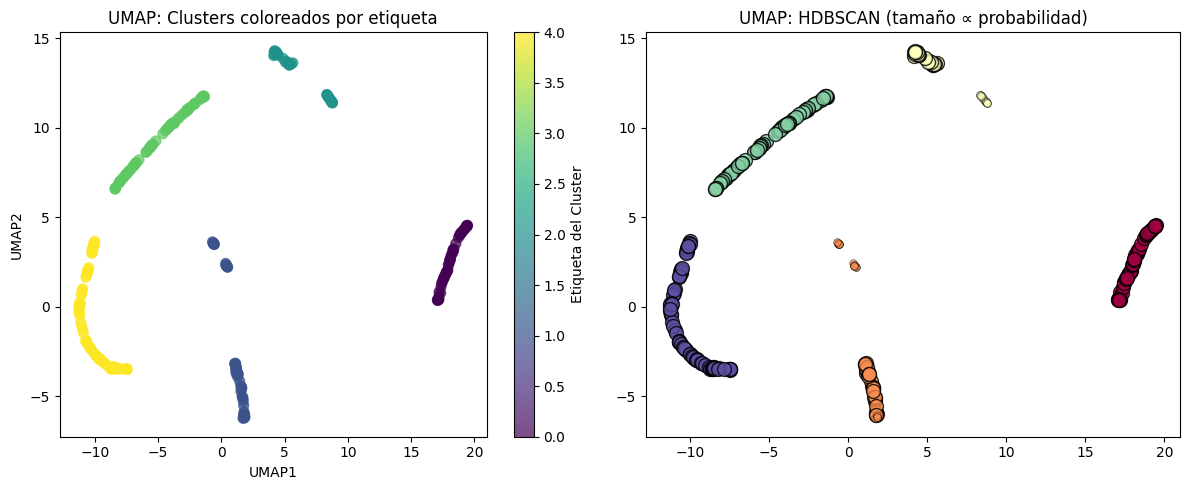

In [65]:
plot_umap_hdbscan(df_comorbilidades_grupo_1, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


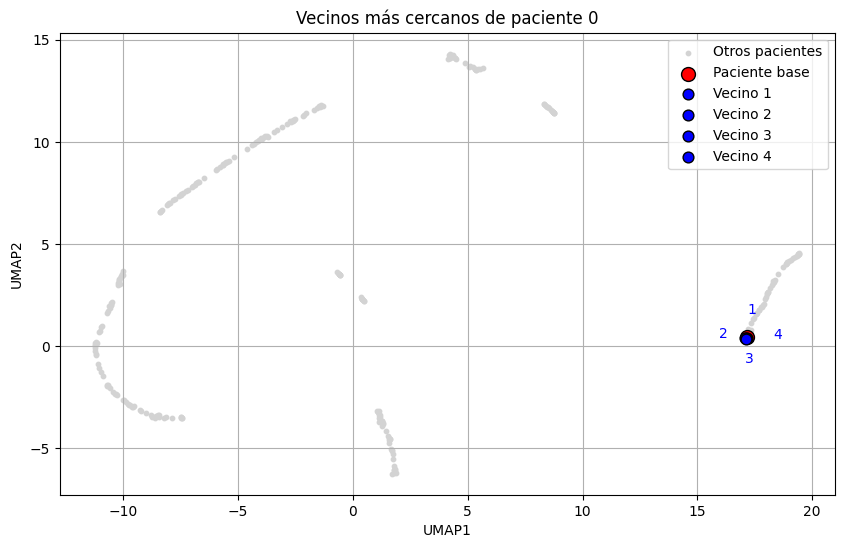

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX      DIAG ING/INPAT  \
0     Paciente base          44        75   FEMALE  COVID19 - POSITIVO   
307               1          27        60     MALE  COVID19 - POSITIVO   
1100              2          28        63     MALE  COVID19 - POSITIVO   
403               3          21        64     MALE  COVID19 - POSITIVO   
1577              4          11        59     MALE  COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
0              RELVAR ELLIPTA inh (92+22) mcg/inh                  1   
307                         NORAGES amp 8 mg/4 mL                 34   
1100                   PARACETAMOL sol 1 g/100 mL                  2   
403            RELVAR ELLIPTA inh (92+22) mcg/inh                  1   
1577                        NORAGES amp 8 mg/4 mL                  6   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
0               35.9                 2           Se detecta   
307             36.5                 2           Se detecta   
1100            37.1                 2        No se detecta   
403             37.0                 2                  5.2   
1577            35.3                 2           Se detecta   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
0                            Domicilio  
307                          Domicilio  
1100                         Domicilio  
403                      Fallecimiento  
1577                         Domicilio

In [171]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_1,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_1),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [66]:
# Pacientes con covid-19 sin comorbilidades
df_comorbilidades_grupo_2 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [67]:
df_comorbilidades_grupo_2.describe()

PATIENT ID    EDAD/AGE    SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count   133.000000  133.000000  133.000000         133.000000   
mean   1683.939850   65.676692    0.458647           6.721805   
std    1031.388126   16.029589    0.500171           4.032732   
min      51.000000   33.000000    0.000000           1.000000   
25%     837.000000   55.000000    0.000000           4.000000   
50%    1740.000000   68.000000    0.000000           7.000000   
75%    2320.000000   79.000000    1.000000           8.000000   
max    4408.000000   97.000000    1.000000          19.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                133.0              133.0                      133.0   
mean                   0.0                0.0                        0.0   
std                    0.0                0.0                        0.0   
min                    0.0                0.0                        0.0   
25%                    0.0                0.0                        0.0   
50%                    0.0                0.0                        0.0   
75%                    0.0                0.0                        0.0   
max                    0.0                0.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                     133.0                      133.0   
mean                        0.0                        0.0   
std                         0.0                        0.0   
min                         0.0                        0.0   
25%                         0.0                        0.0   
50%                         0.0                        0.0   
75%                         0.0                        0.0   
max                         0.0                        0.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count               133.0          133.0          133.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                       133.0     133.0                      133.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                        133.0                            133.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count               133.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 2: Pacientes con covid-19
- Media de edad: 57 años
- Rango de edad: 15 a 97 años
- media de días de hospitalización: 1.02
- Pacientes: 822

In [68]:
# Criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_2)
min_cluster_size = int(dataset_size * 0.02)  # 2% = 20 puntos
print(f"Minimum cluster size: {min_cluster_size}")


Minimum cluster size: 2


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


133
Número de clusters encontrados: 2
Número de puntos de anomalías: 0


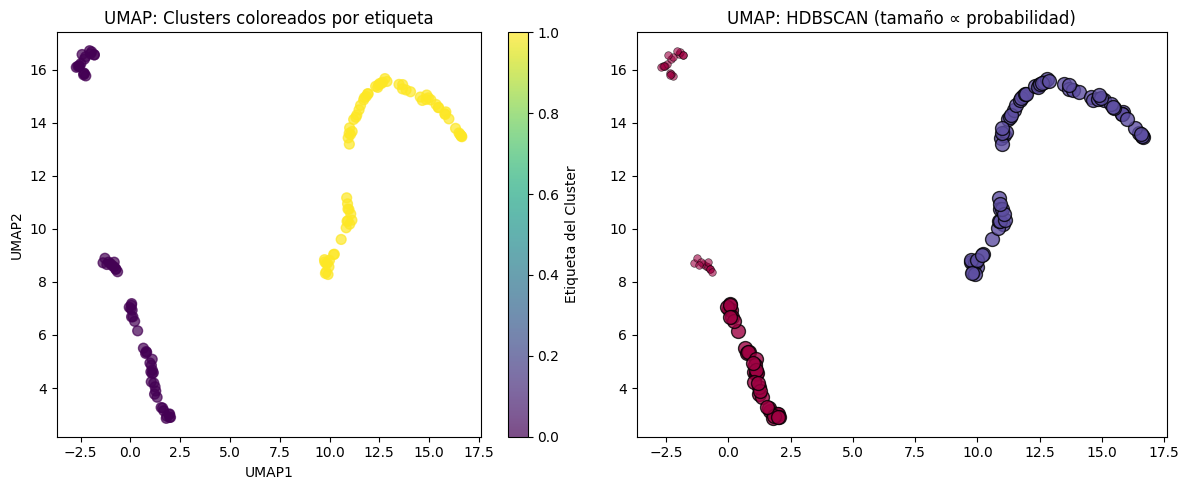

In [69]:
plot_umap_hdbscan(df_comorbilidades_grupo_2, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


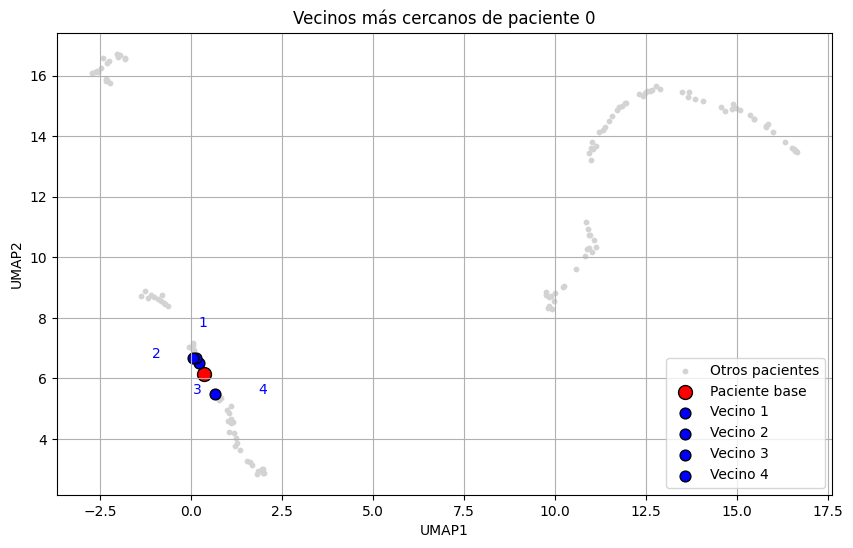

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX       DIAG ING/INPAT  \
89    Paciente base         903        77   FEMALE   COVID19 - POSITIVO   
1836              1         871        93   FEMALE  COVID19 - PENDIENTE   
1555              2         837        78   FEMALE   COVID19 - POSITIVO   
2226              3         840        81     MALE   COVID19 - POSITIVO   
491               4         957        88     MALE   COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
89                       BUSCAPINA amp 20 mg/1 mL                 11   
1836                   PARACETAMOL sol 1 g/100 mL                  3   
1555                         DOLQUINE comp 200 mg                  2   
2226             MORFINA amp 1% 1 mL (10 mg/1 mL)                  4   
491                           TENORMIN comp 50 mg                  7   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
89              36.1                 2                 12.7   
1836            36.4                 2                 12.3   
1555            36.6                 2                 16.1   
2226            36.0                 2                 17.3   
491             35.8                 2             Negativo   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
89                Traslado al Hospital  
1836                         Domicilio  
1555                     Fallecimiento  
2226                         Domicilio  
491                          Domicilio

In [172]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_2,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_2),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [70]:
# Paciente con covid-19, hipertensión y enf. respiratoria
df_comorbilidades_grupo_3 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [71]:
df_comorbilidades_grupo_3.describe()

PATIENT ID     EDAD/AGE     SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count  1054.000000  1054.000000  1054.000000        1054.000000   
mean   1926.806452    62.313093     0.614801           8.294118   
std    1209.952611    16.167472     0.486873           5.913015   
min       5.000000     1.000000     0.000000           1.000000   
25%     967.500000    51.000000     0.000000           5.000000   
50%    1761.500000    62.000000     1.000000           7.000000   
75%    2784.500000    74.000000     1.000000          10.000000   
max    4471.000000   100.000000     1.000000          37.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count               1054.0             1054.0                     1054.0   
mean                   1.0                0.0                        0.0   
std                    0.0                0.0                        0.0   
min                    1.0                0.0                        0.0   
25%                    1.0                0.0                        0.0   
50%                    1.0                0.0                        0.0   
75%                    1.0                0.0                        0.0   
max                    1.0                0.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                    1054.0                     1054.0   
mean                        0.0                        1.0   
std                         0.0                        0.0   
min                         0.0                        1.0   
25%                         0.0                        1.0   
50%                         0.0                        1.0   
75%                         0.0                        1.0   
max                         0.0                        1.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count              1054.0         1054.0         1054.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                      1054.0    1054.0                     1054.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                       1054.0                           1054.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count              1054.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 3: Pacientes con covid-19, hipertensión arterial y enfermedad respitatoria crónica
- Media de edad: 75 años
- Rango de edad: 47 a 99 años
- media de días de hospitalización: 1.48
- Pacientes: 530

In [72]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_3)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 21


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


1054
Número de clusters encontrados: 9
Número de puntos de anomalías: 25


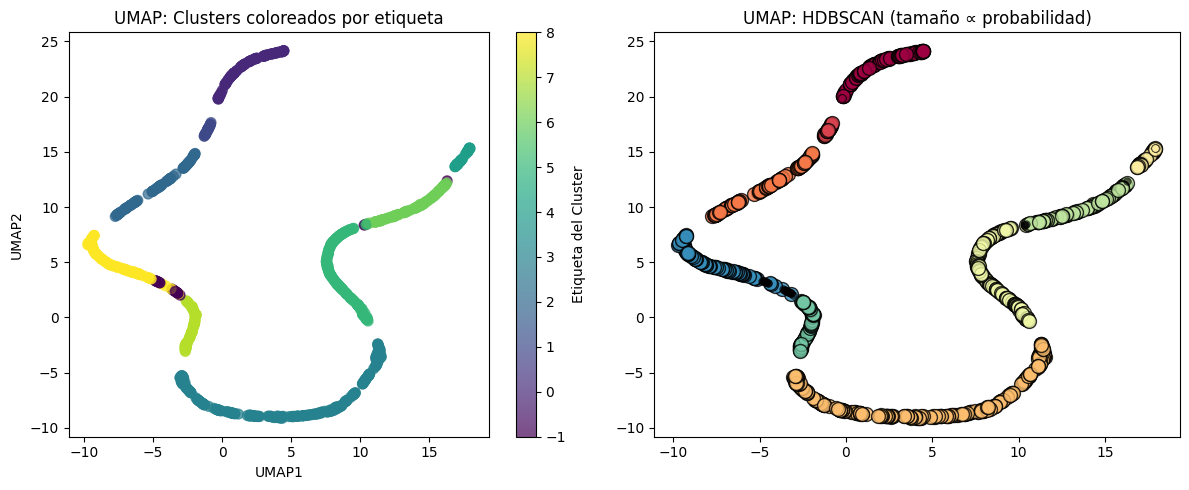

In [73]:
plot_umap_hdbscan(df_comorbilidades_grupo_3, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


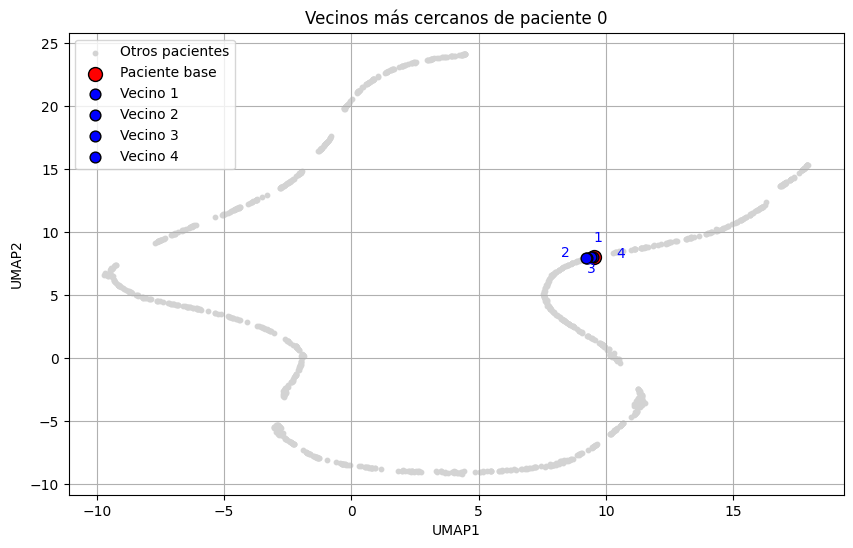

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX       DIAG ING/INPAT  \
5     Paciente base         589        55     MALE  COVID19 - PENDIENTE   
9                 1         594        55   FEMALE   COVID19 - POSITIVO   
8                 2         595        49   FEMALE  COVID19 - PENDIENTE   
2059              3         610        83   FEMALE   COVID19 - POSITIVO   
2045              4         620        86   FEMALE  COVID19 - PENDIENTE   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
5                      PARACETAMOL sol 1 g/100 mL                  4   
9                    VENTOLIN aerosol 100 mcg/inh                  8   
8                            PARACETAMOL comp 1 g                  6   
2059           RELVAR ELLIPTA inh (92+22) mcg/inh                 11   
2045                         DOLQUINE comp 200 mg                 13   

      TEMP_ING/INPAT  SAT_02_ING/INPAT       RESULTADO/VAL_RESULT  \
5               35.3                 2                 Se detecta   
9               36.5                 2  No se detecta ADN de CMV.   
8               36.0                 2                       12.7   
2059            35.3                 2                       14.6   
2045            36.2                 2                       11.3   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
5                            Domicilio  
9                            Domicilio  
8                            Domicilio  
2059                         Domicilio  
2045                         Domicilio

In [173]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_3,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_3),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [74]:
# Paciente con covid-19 e hipertensión
df_comorbilidades_grupo_4 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [75]:
df_comorbilidades_grupo_4.describe()

PATIENT ID    EDAD/AGE    SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count   567.000000  567.000000  567.000000         567.000000   
mean   1849.883598   61.832451    0.580247           7.846561   
std    1152.783508   15.866553    0.493954           5.341624   
min       2.000000   15.000000    0.000000           1.000000   
25%     929.000000   50.000000    0.000000           4.000000   
50%    1686.000000   62.000000    1.000000           7.000000   
75%    2666.500000   73.000000    1.000000          10.000000   
max    4469.000000   99.000000    1.000000          37.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                567.0              567.0                      567.0   
mean                   1.0                0.0                        0.0   
std                    0.0                0.0                        0.0   
min                    1.0                0.0                        0.0   
25%                    1.0                0.0                        0.0   
50%                    1.0                0.0                        0.0   
75%                    1.0                0.0                        0.0   
max                    1.0                0.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                     567.0                      567.0   
mean                        0.0                        0.0   
std                         0.0                        0.0   
min                         0.0                        0.0   
25%                         0.0                        0.0   
50%                         0.0                        0.0   
75%                         0.0                        0.0   
max                         0.0                        0.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count               567.0          567.0          567.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                       567.0     567.0                      567.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                        567.0                            567.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count               567.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 4: Pacientes con covid-19 e hipertensión arterial
- Media de edad: 70 años
- Rango de edad: 39 a 99 años
- media de días de hospitalización: 1.09
- Pacientes: 306

In [76]:
# Criterio de selección del tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_4)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 11


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


284
Número de clusters encontrados: 5
Número de puntos de anomalías: 0


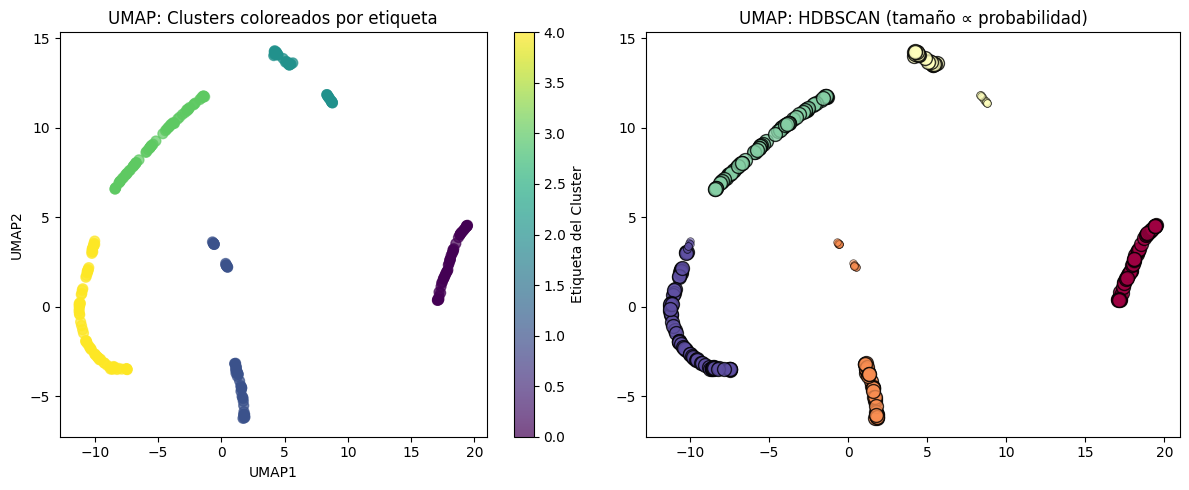

In [77]:
plot_umap_hdbscan(df_comorbilidades_grupo_1, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


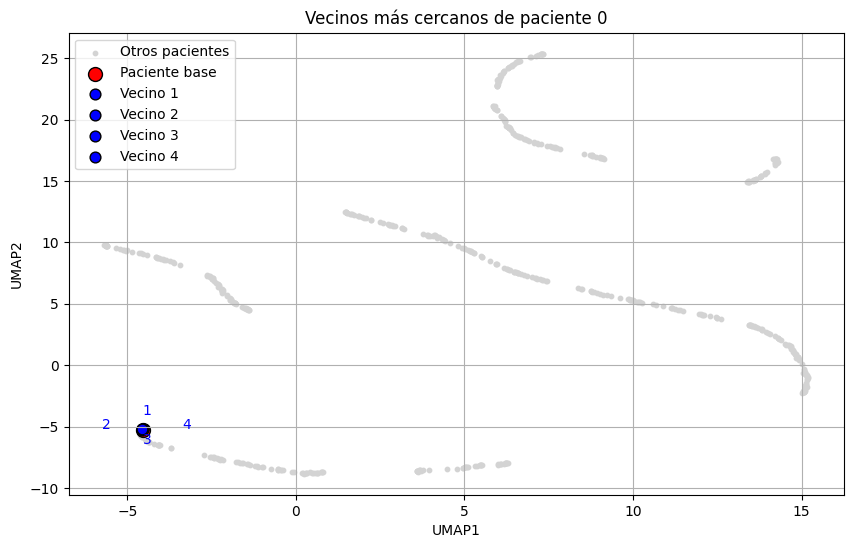

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX      DIAG ING/INPAT  \
23    Paciente base         640        51   FEMALE  COVID19 - POSITIVO   
31                1         648        56     MALE  COVID19 - POSITIVO   
2072              2         629        55     MALE  COVID19 - POSITIVO   
2062              3         607        72     MALE  COVID19 - POSITIVO   
2200              4         617        80   FEMALE  COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
23                          CODEISAN comp 28,7 mg                 10   
31                           PARACETAMOL comp 1 g                 11   
2072                         DOLQUINE comp 200 mg                 11   
2062                         DOLQUINE comp 200 mg                 13   
2200                         PARACETAMOL comp 1 g                  4   

      TEMP_ING/INPAT  SAT_02_ING/INPAT  \
23              36.3                 2   
31              36.0                 2   
2072            36.3                 2   
2062            36.0                 2   
2200            36.0                 2   

                                   RESULTADO/VAL_RESULT  \
23                                                 13.2   
31                                                 0.02   
2072  PoblaciÂ¢n analizada: Linfocitaria (12.4%). Se...   
2062                                                9.4   
2200                                      No se detecta   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
23                           Domicilio  
31                           Domicilio  
2072                         Domicilio  
2062                         Domicilio  
2200                         Domicilio

In [174]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_4,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_4),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [78]:
# Paciente con covid-19, hipertension, diabetes y enf. respiratoria
df_comorbilidades_grupo_5 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [79]:
df_comorbilidades_grupo_5.describe()

PATIENT ID    EDAD/AGE    SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count   128.000000  128.000000  128.000000         128.000000   
mean   1864.179688   73.335938    0.632812           7.734375   
std    1170.089131   12.092346    0.483932           6.042480   
min      75.000000   42.000000    0.000000           1.000000   
25%     901.250000   64.000000    0.000000           4.000000   
50%    1830.000000   74.000000    1.000000           7.000000   
75%    2456.750000   84.000000    1.000000           9.000000   
max    4359.000000   98.000000    1.000000          37.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                128.0              128.0                      128.0   
mean                   1.0                1.0                        0.0   
std                    0.0                0.0                        0.0   
min                    1.0                1.0                        0.0   
25%                    1.0                1.0                        0.0   
50%                    1.0                1.0                        0.0   
75%                    1.0                1.0                        0.0   
max                    1.0                1.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                     128.0                      128.0   
mean                        0.0                        1.0   
std                         0.0                        0.0   
min                         0.0                        1.0   
25%                         0.0                        1.0   
50%                         0.0                        1.0   
75%                         0.0                        1.0   
max                         0.0                        1.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count               128.0          128.0          128.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                       128.0     128.0                      128.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                        128.0                            128.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count               128.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 5: Pacientes con covid-19, hipertensión arterial, diabetes y enfermedad respiratoria crónica
- Media de edad: 75 años
- Rango de edad: 53 a 98 años
- media de días de hospitalización: 1.15
- Pacientes: 138

In [80]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_5)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 2


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


128
Número de clusters encontrados: 2
Número de puntos de anomalías: 0


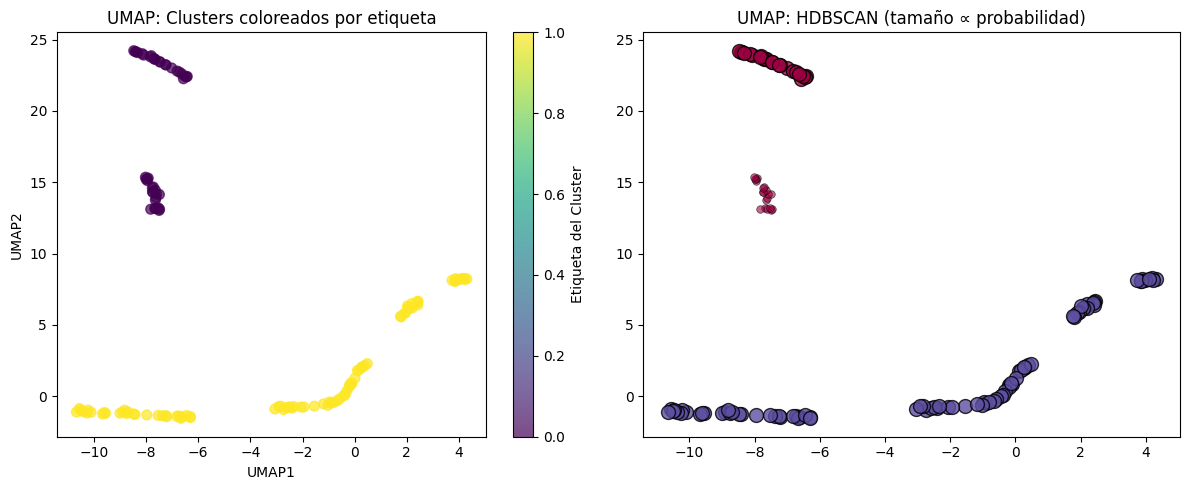

In [81]:
plot_umap_hdbscan(df_comorbilidades_grupo_5, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


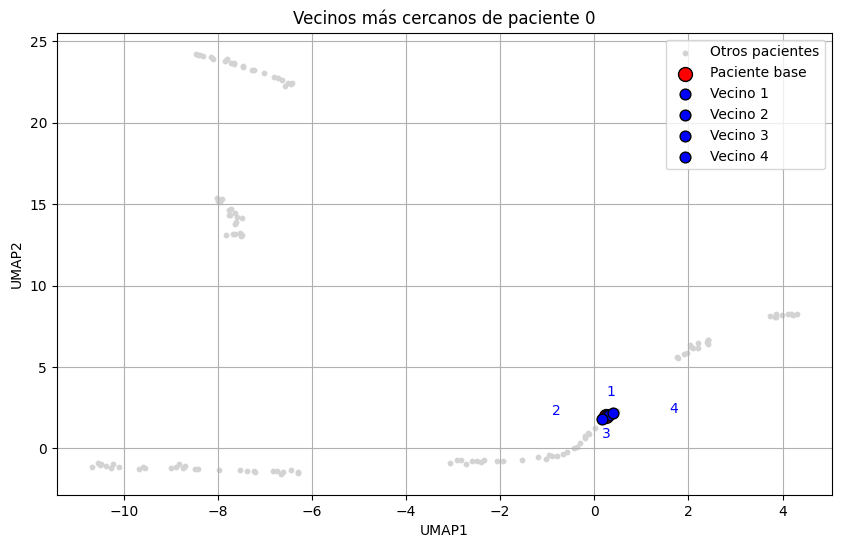

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX       DIAG ING/INPAT  \
33    Paciente base         655        85     MALE   COVID19 - POSITIVO   
2069              1         635        75     MALE   COVID19 - POSITIVO   
34                2         654        74     MALE   COVID19 - POSITIVO   
516               3         703        61     MALE  COVID19 - PENDIENTE   
42                4         653        82     MALE   COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
33                   VENTOLIN aerosol 100 mcg/inh                  7   
2069                         DOLQUINE comp 200 mg                  4   
34                           PARACETAMOL comp 1 g                 11   
516                          DOLQUINE comp 200 mg                  4   
42                          CARVEDILOL comp 25 mg                  2   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
33              37.7                 2        No se detecta   
2069            35.4                 2                 20.7   
34              35.0                 2                 0.28   
516             35.7                 2                334.0   
42              36.0                 2        No se detecta   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
33                           Domicilio  
2069                         Domicilio  
34                       Fallecimiento  
516                          Domicilio  
42                           Domicilio

In [175]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_5,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_5),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [82]:
# Paciente con covid-19, hipertension, enf. renal y respiratoria
df_comorbilidades_grupo_6 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 1) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [83]:
df_comorbilidades_grupo_6.describe()

PATIENT ID    EDAD/AGE   SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count    94.000000   94.000000  94.000000          94.000000   
mean   1687.978723   81.372340   0.606383           8.776596   
std    1200.740614   10.844932   0.491171           6.707650   
min      19.000000   50.000000   0.000000           1.000000   
25%     624.000000   75.000000   0.000000           5.000000   
50%    1512.000000   84.000000   1.000000           7.000000   
75%    2517.750000   88.750000   1.000000          10.000000   
max    4327.000000  105.000000   1.000000          38.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                 94.0               94.0                       94.0   
mean                   1.0                0.0                        0.0   
std                    0.0                0.0                        0.0   
min                    1.0                0.0                        0.0   
25%                    1.0                0.0                        0.0   
50%                    1.0                0.0                        0.0   
75%                    1.0                0.0                        0.0   
max                    1.0                0.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                      94.0                       94.0   
mean                        1.0                        1.0   
std                         0.0                        0.0   
min                         1.0                        1.0   
25%                         1.0                        1.0   
50%                         1.0                        1.0   
75%                         1.0                        1.0   
max                         1.0                        1.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count                94.0           94.0           94.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                        94.0      94.0                       94.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                         94.0                             94.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count                94.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 6: Pacientes con covid-19, hipertensión arterial, enfermedad renal y enfermedad respiratoria crónica
- Media de edad: 82 años
- Rango de edad: 59 a 105 años
- media de días de hospitalización: 3.23
- Pacientes: 118

In [84]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_6)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 1


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


94
Número de clusters encontrados: 2
Número de puntos de anomalías: 75


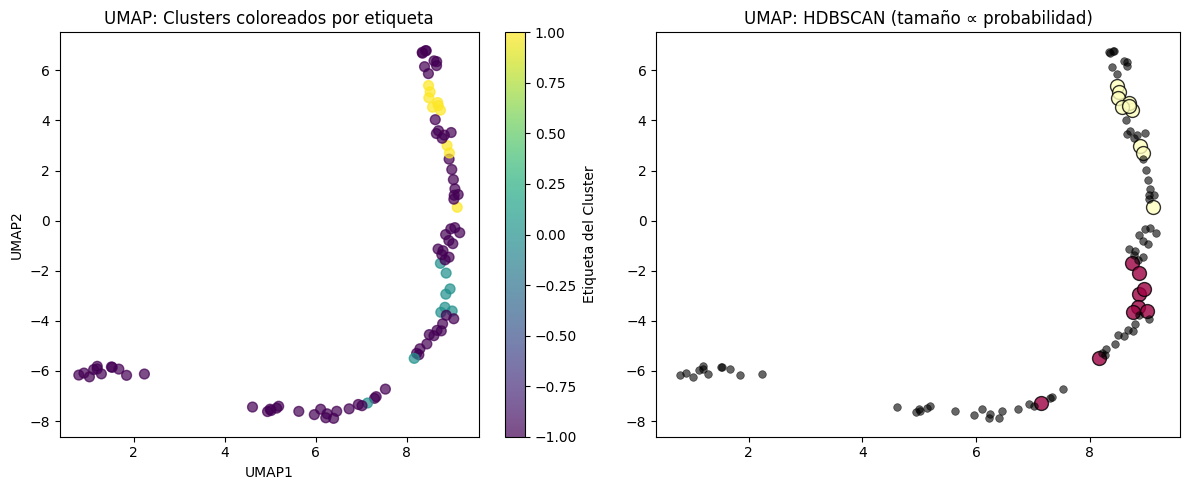

In [85]:
plot_umap_hdbscan(df_comorbilidades_grupo_6, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


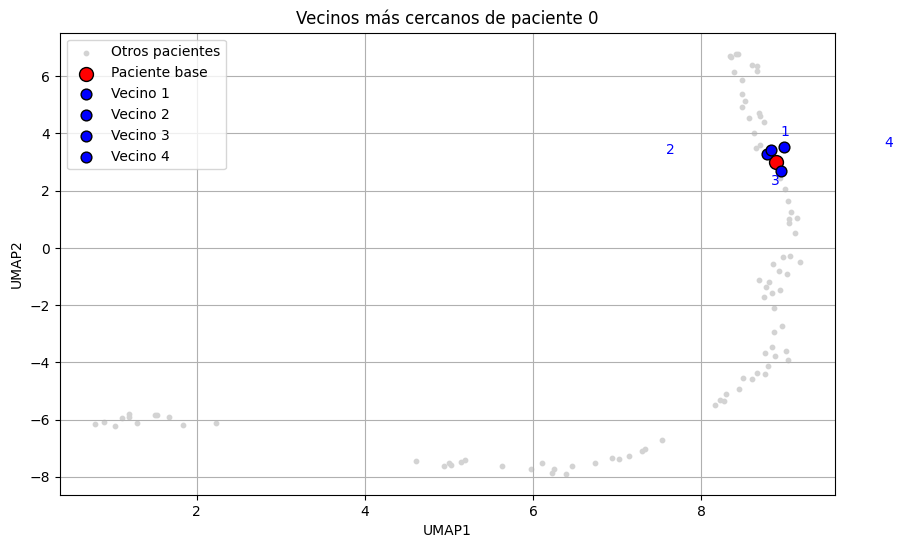

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX      DIAG ING/INPAT  \
6     Paciente base         590        86   FEMALE  COVID19 - POSITIVO   
2060              1         615        85   FEMALE  COVID19 - POSITIVO   
2082              2         522        86   FEMALE  COVID19 - POSITIVO   
2013              3         523        90   FEMALE  COVID19 - POSITIVO   
2011              4         524       105   FEMALE  COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
6                      AGUA BIDESTILADA amp 10 mL                  2   
2060             MORFINA amp 1% 1 mL (10 mg/1 mL)                 13   
2082                      CEFTRIAXONA vial IV 1 g                  9   
2013                         DOLQUINE comp 200 mg                  7   
2011                         DOLQUINE comp 200 mg                  8   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
6               36.0                 2        No se detecta   
2060            36.5                 2                 10.1   
2082            36.5                 2                 12.2   
2013            36.4                 2                 13.7   
2011            36.3                 2                 10.1   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
6                        Fallecimiento  
2060                     Fallecimiento  
2082                         Domicilio  
2013                         Domicilio  
2011                         Domicilio

In [176]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_6,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_6),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [86]:
# Paciente con covid-19, hipertension, enf. renal y respiratoria
df_comorbilidades_grupo_7 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 1) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [87]:
df_comorbilidades_grupo_7.describe()

PATIENT ID    EDAD/AGE    SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count   109.000000  109.000000  109.000000         109.000000   
mean   2169.211009   71.688073    0.541284           7.844037   
std    1085.949159   12.165295    0.500594           5.794592   
min      96.000000   27.000000    0.000000           1.000000   
25%    1370.000000   64.000000    0.000000           5.000000   
50%    2210.000000   72.000000    1.000000           7.000000   
75%    2804.000000   80.000000    1.000000          10.000000   
max    4421.000000   94.000000    1.000000          37.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                109.0              109.0                      109.0   
mean                   1.0                1.0                        0.0   
std                    0.0                0.0                        0.0   
min                    1.0                1.0                        0.0   
25%                    1.0                1.0                        0.0   
50%                    1.0                1.0                        0.0   
75%                    1.0                1.0                        0.0   
max                    1.0                1.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                     109.0                      109.0   
mean                        0.0                        0.0   
std                         0.0                        0.0   
min                         0.0                        0.0   
25%                         0.0                        0.0   
50%                         0.0                        0.0   
75%                         0.0                        0.0   
max                         0.0                        0.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count               109.0          109.0          109.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                       109.0     109.0                      109.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                        109.0                            109.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count               109.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 7: Pacientes con covid-19, hipertensión arterial y diabetes
- Media de edad: 82 años
- Rango de edad: 50 a 94 años
- media de días de hospitalización: 1
- Pacientes: 118

In [88]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_7)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 2


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


109
Número de clusters encontrados: 2
Número de puntos de anomalías: 12


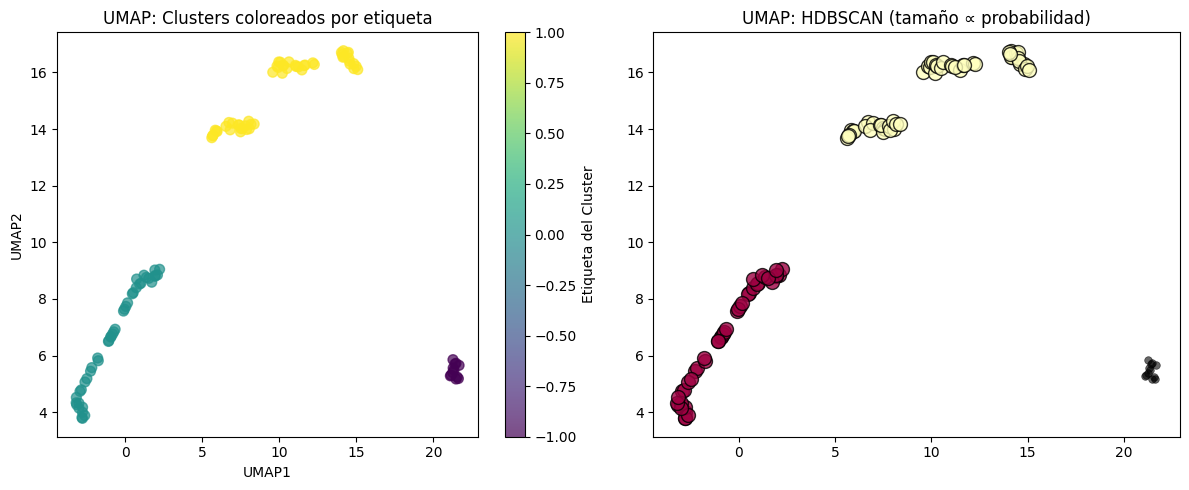

In [89]:
plot_umap_hdbscan(df_comorbilidades_grupo_7, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


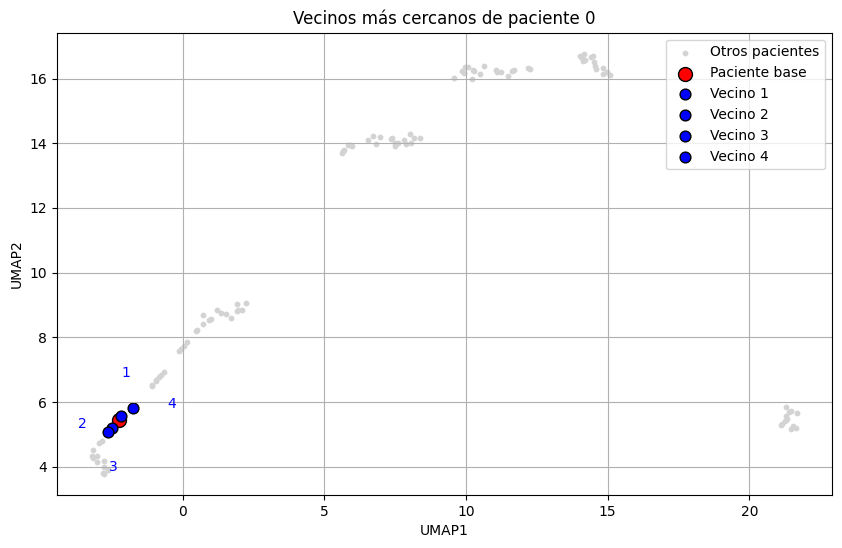

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX       DIAG ING/INPAT  \
84    Paciente base         908        69   FEMALE   COVID19 - POSITIVO   
455               1         941        55     MALE   COVID19 - POSITIVO   
1842              2         861        74   FEMALE  COVID19 - PENDIENTE   
1244              3         790        78     MALE   COVID19 - POSITIVO   
784               4        1016        59     MALE   COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
84        BROMURO IPRATROPIO aerosol 250 mcg/1 mL                 11   
455                          DOLQUINE comp 200 mg                  3   
1842                              ACFOL comp 5 mg                  4   
1244                 HIDROXICLOROQUINA comp 200mg                  6   
784                  VENTOLIN aerosol 100 mcg/inh                  3   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
84              36.3                 2                  9.9   
455             36.0                 2                  9.9   
1842            35.0                 2                 14.3   
1244            36.1                 2           Se detecta   
784             36.0                 2                 10.4   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
84                Traslado al Hospital  
455                          Domicilio  
1842                         Domicilio  
1244                         Domicilio  
784                          Domicilio

In [177]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_7,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_7),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [90]:
# Paciente con covid-19, diabetes y enf. respiratoria
df_comorbilidades_grupo_8 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [91]:
df_comorbilidades_grupo_8.describe()

PATIENT ID   EDAD/AGE   SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count    41.000000  41.000000  41.000000          41.000000   
mean   1693.878049  73.682927   0.512195           8.390244   
std    1175.399596  13.256016   0.506061           7.221073   
min     167.000000  39.000000   0.000000           1.000000   
25%     715.000000  64.000000   0.000000           4.000000   
50%    1495.000000  74.000000   1.000000           7.000000   
75%    2192.000000  85.000000   1.000000           9.000000   
max    4333.000000  91.000000   1.000000          37.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                 41.0               41.0                       41.0   
mean                   0.0                1.0                        0.0   
std                    0.0                0.0                        0.0   
min                    0.0                1.0                        0.0   
25%                    0.0                1.0                        0.0   
50%                    0.0                1.0                        0.0   
75%                    0.0                1.0                        0.0   
max                    0.0                1.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                      41.0                       41.0   
mean                        0.0                        1.0   
std                         0.0                        0.0   
min                         0.0                        1.0   
25%                         0.0                        1.0   
50%                         0.0                        1.0   
75%                         0.0                        1.0   
max                         0.0                        1.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count                41.0           41.0           41.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                        41.0      41.0                       41.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                         41.0                             41.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count                41.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 8: Pacientes con covid-19, diabetes y enfermedad respiratoria crónica
- Media de edad: 70 años
- Rango de edad: 39 a 91 años
- media de días de hospitalización: 1.34
- Pacientes: 92

In [92]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_8)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 0


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


41
Número de clusters encontrados: 0
Número de puntos de anomalías: 41


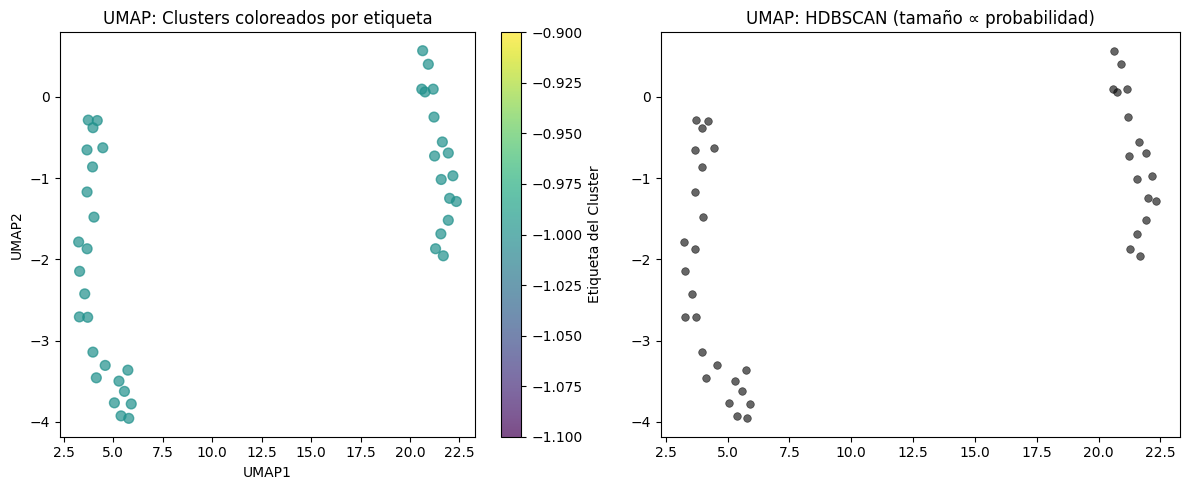

In [93]:
plot_umap_hdbscan(df_comorbilidades_grupo_8, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


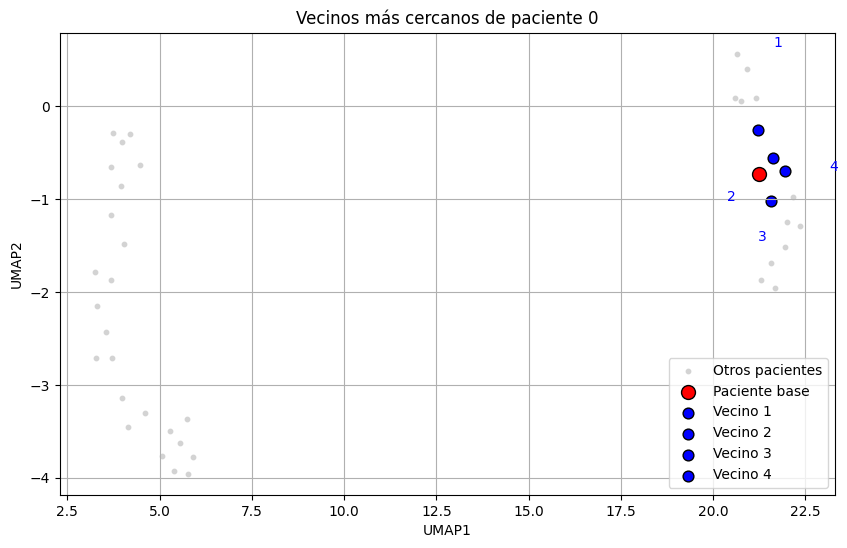

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX       DIAG ING/INPAT  \
15    Paciente base         601        57     MALE   COVID19 - POSITIVO   
28                1         645        76     MALE   COVID19 - POSITIVO   
569               2         699        86   FEMALE  COVID19 - PENDIENTE   
1749              3         512        91     MALE   COVID19 - POSITIVO   
2068              4         630        85   FEMALE   COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
15                          NORAGES amp 8 mg/4 mL                 10   
28                           DOLQUINE comp 200 mg                 11   
569                           TENORMIN comp 50 mg                 11   
1749                 VENTOLIN aerosol 100 mcg/inh                  8   
2068                         BISOPROLOL comp 5 mg                 12   

      TEMP_ING/INPAT  SAT_02_ING/INPAT               RESULTADO/VAL_RESULT  \
15              36.0                 2                      No se detecta   
28              35.0                 2                               35.4   
569             35.0                 2  Enviado al Hospital 12 de Octubre   
1749            36.8                 2                               16.1   
2068            36.4                 2                               14.4   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
15                           Domicilio  
28                           Domicilio  
569                          Domicilio  
1749                         Domicilio  
2068                         Domicilio

In [178]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_8,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_8),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [94]:
# Paciente con covid-19 y diabetes
df_comorbilidades_grupo_9 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 1) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 0) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 0) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [95]:
df_comorbilidades_grupo_9.describe()

PATIENT ID   EDAD/AGE   SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count    31.000000  31.000000  31.000000          31.000000   
mean   1582.064516  71.516129   0.516129           7.935484   
std    1141.119507  13.710996   0.508001           6.612793   
min      58.000000  39.000000   0.000000           1.000000   
25%     648.000000  63.500000   0.000000           5.000000   
50%    1516.000000  75.000000   1.000000           7.000000   
75%    2508.500000  84.500000   1.000000           7.500000   
max    3780.000000  89.000000   1.000000          34.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                 31.0               31.0                       31.0   
mean                   0.0                1.0                        0.0   
std                    0.0                0.0                        0.0   
min                    0.0                1.0                        0.0   
25%                    0.0                1.0                        0.0   
50%                    0.0                1.0                        0.0   
75%                    0.0                1.0                        0.0   
max                    0.0                1.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                      31.0                       31.0   
mean                        0.0                        0.0   
std                         0.0                        0.0   
min                         0.0                        0.0   
25%                         0.0                        0.0   
50%                         0.0                        0.0   
75%                         0.0                        0.0   
max                         0.0                        0.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count                31.0           31.0           31.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                        31.0      31.0                       31.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                         31.0                             31.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count                31.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 9: Pacientes con covid-19 y diabetes
- Media de edad: 68 años
- Rango de edad: 39 a 88 años
- media de días de hospitalización: 1.57
- Pacientes: 70

In [96]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_9)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 0


31
Número de clusters encontrados: 0
Número de puntos de anomalías: 31


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


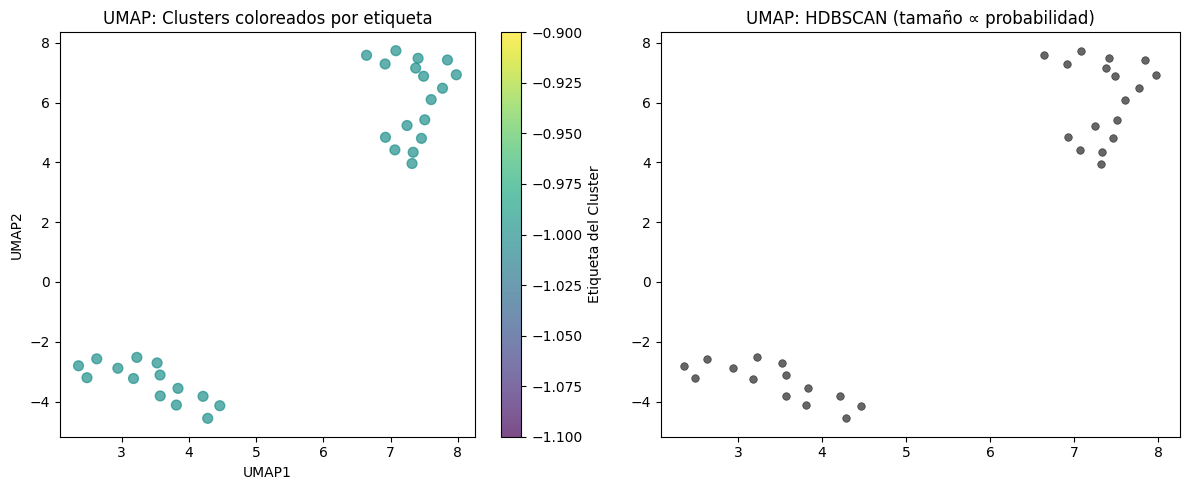

In [97]:
plot_umap_hdbscan(df_comorbilidades_grupo_9, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


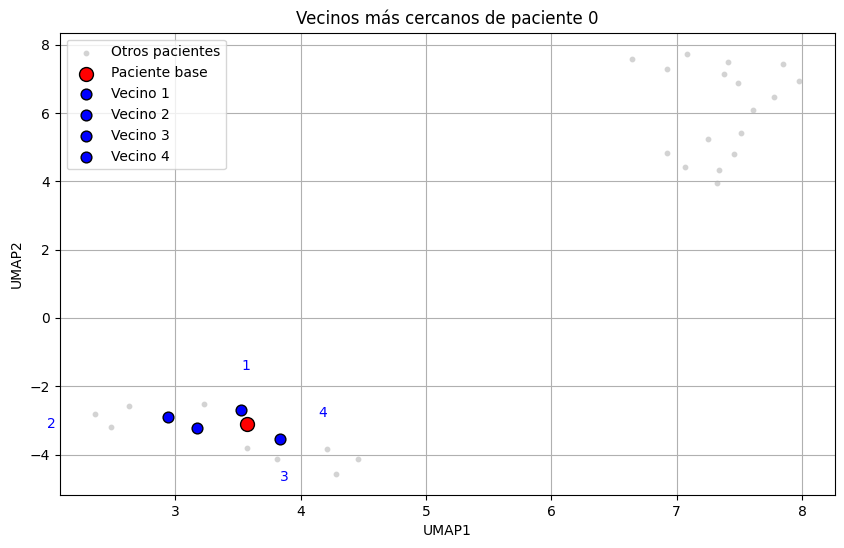

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX       DIAG ING/INPAT  \
17    Paciente base         591        45   FEMALE  COVID19 - PENDIENTE   
1781              1         498        57     MALE   COVID19 - POSITIVO   
1530              2         482        84     MALE   COVID19 - POSITIVO   
502               3         714        39   FEMALE   COVID19 - POSITIVO   
905               4         388        80   FEMALE   COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
17                   TOSEINA sol 2 mg/mL F/250 mL                  6   
1781                         DOLQUINE comp 200 mg                  8   
1530                      CARVEDILOL comp 6,25 mg                  2   
502                         CODEISAN comp 28,7 mg                  5   
905                    AGUA BIDESTILADA amp 10 mL                  6   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
17              37.6                 2                 13.4   
1781            36.8                 2                 12.8   
1530            35.5                 2                 -2.6   
502             35.6                 2                 18.9   
905             36.6                 2        No se detecta   

     MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
17                           Domicilio  
1781                         Domicilio  
1530                         Domicilio  
502                          Domicilio  
905                          Domicilio

In [179]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_9,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_9),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


In [98]:
# Paciente con covid-19, enf. renal y respiratoria
df_comorbilidades_grupo_10 = df_comorbilidades[(df_comorbilidades['HIPER_ART/ART_HYPER'] == 0) &
(df_comorbilidades['DIABETES/DIABETES'] == 0) &
(df_comorbilidades['ENF_CARDIO/CARDIO_DISEASE'] == 0) &
(df_comorbilidades['ENF_RENAL/KIDNEY_DISEASE'] == 1) &
(df_comorbilidades['ENF_RESPIRA/RESPI_DISEASE'] == 1) &
(df_comorbilidades['OBESITIDAD/OBESITY'] == 0) &
(df_comorbilidades['CANCER/CANCER'] == 0) &
(df_comorbilidades['INMUNO/IMMUNO'] == 0) &
(df_comorbilidades['ENF_HEPATICA/LIVER_DISEASE'] == 0) &
(df_comorbilidades['VIH/SIDA'] == 0) &
(df_comorbilidades['TUBERCULOSIS/TUBERCULOSIS'] == 0) &
(df_comorbilidades['TRAST_NEURO/NEURO_DISORDERS'] == 0) &
(df_comorbilidades['TRAST_CEL_FALCI/SICKLE_CELL_DIS'] == 0) &
(df_comorbilidades['TABAQUISMO/SMOKING'] == 0)]

In [99]:
df_comorbilidades_grupo_10.describe()

PATIENT ID    EDAD/AGE   SEXO/SEX  UCI_DIAS/ICU_DAYS  \
count    48.000000   48.000000  48.000000          48.000000   
mean   2118.750000   77.812500   0.645833           9.479167   
std    1119.620139   11.562331   0.483321           8.150159   
min     101.000000   52.000000   0.000000           1.000000   
25%    1549.000000   70.750000   0.000000           5.000000   
50%    1965.500000   76.000000   1.000000           7.000000   
75%    2595.000000   88.000000   1.000000          11.000000   
max    4366.000000  106.000000   1.000000          38.000000   

       HIPER_ART/ART_HYPER  DIABETES/DIABETES  ENF_CARDIO/CARDIO_DISEASE  \
count                 48.0               48.0                       48.0   
mean                   0.0                0.0                        0.0   
std                    0.0                0.0                        0.0   
min                    0.0                0.0                        0.0   
25%                    0.0                0.0                        0.0   
50%                    0.0                0.0                        0.0   
75%                    0.0                0.0                        0.0   
max                    0.0                0.0                        0.0   

       ENF_RENAL/KIDNEY_DISEASE  ENF_RESPIRA/RESPI_DISEASE  \
count                      48.0                       48.0   
mean                        1.0                        1.0   
std                         0.0                        0.0   
min                         1.0                        1.0   
25%                         1.0                        1.0   
50%                         1.0                        1.0   
75%                         1.0                        1.0   
max                         1.0                        1.0   

       OBESITIDAD/OBESITY  CANCER/CANCER  INMUNO/IMMUNO  \
count                48.0           48.0           48.0   
mean                  0.0            0.0            0.0   
std                   0.0            0.0            0.0   
min                   0.0            0.0            0.0   
25%                   0.0            0.0            0.0   
50%                   0.0            0.0            0.0   
75%                   0.0            0.0            0.0   
max                   0.0            0.0            0.0   

       ENF_HEPATICA/LIVER_DISEASE  VIH/SIDA  TUBERCULOSIS/TUBERCULOSIS  \
count                        48.0      48.0                       48.0   
mean                          0.0       0.0                        0.0   
std                           0.0       0.0                        0.0   
min                           0.0       0.0                        0.0   
25%                           0.0       0.0                        0.0   
50%                           0.0       0.0                        0.0   
75%                           0.0       0.0                        0.0   
max                           0.0       0.0                        0.0   

       TRAST_NEURO/NEURO_DISORDERS  TRAST_CEL_FALCI/SICKLE_CELL_DIS  \
count                         48.0                             48.0   
mean                           0.0                              0.0   
std                            0.0                              0.0   
min                            0.0                              0.0   
25%                            0.0                              0.0   
50%                            0.0                              0.0   
75%                            0.0                              0.0   
max                            0.0                              0.0   

       TABAQUISMO/SMOKING  
count                48.0  
mean                  0.0  
std                   0.0  
min                   0.0  
25%                   0.0  
50%                   0.0  
75%                   0.0  
max                   0.0

Grupo 10: Pacientes con covid-19, enfermedad renal crónica y enfermedad respiratoria crónica
- Media de edad: 78 años
- Rango de edad: 50 a 106 años
- media de días de hospitalización: 2.45
- Pacientes: 66

In [100]:
# criterio estadístico para el tamaño mínimo de los clusters
dataset_size = len(df_comorbilidades_grupo_10)
min_cluster_size = int(dataset_size * 0.02)
print(f"Minimum cluster size: {min_cluster_size}")

Minimum cluster size: 0


48


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Número de clusters encontrados: 2
Número de puntos de anomalías: 19


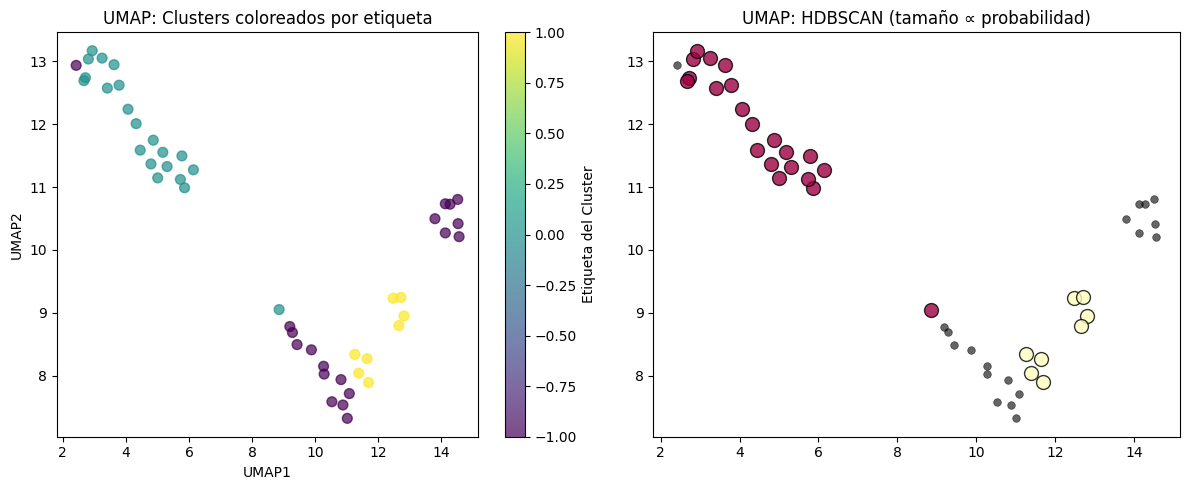

In [101]:
plot_umap_hdbscan(df_comorbilidades_grupo_10, min_cluster_size)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


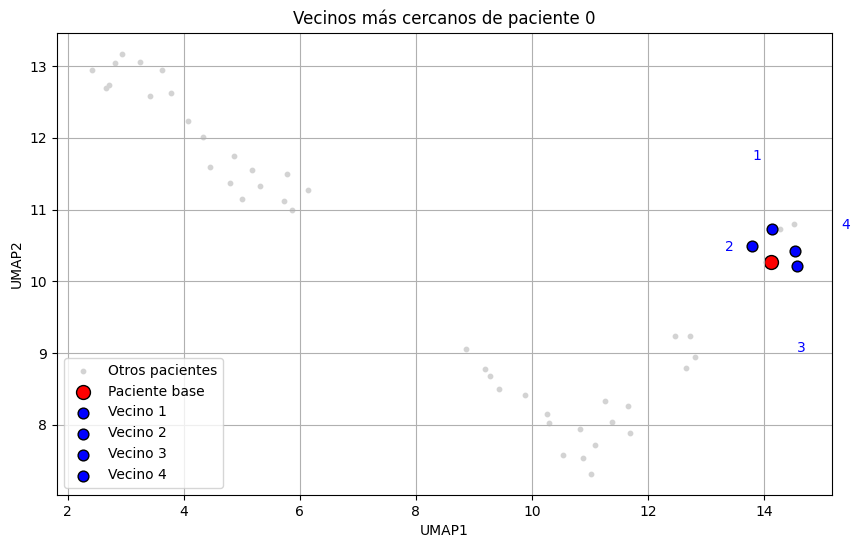

Comparación entre paciente y sus vecinos:


Vecino #  PATIENT ID  EDAD/AGE SEXO/SEX      DIAG ING/INPAT  \
38    Paciente base         658        80     MALE  COVID19 - POSITIVO   
691               1         117        71     MALE  COVID19 - POSITIVO   
2066              2         623        91   FEMALE  COVID19 - POSITIVO   
2057              3         634        98   FEMALE  COVID19 - POSITIVO   
673               4         101        79   FEMALE  COVID19 - POSITIVO   

     FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME  UCI_DIAS/ICU_DAYS  \
38                           BISOPROLOL comp 5 mg                 11   
691                         NORAGES amp 8 mg/4 mL                  5   
2066           TIMOFTOL col 5 mg/mL (0.5%) F/5 mL                 11   
2057             MORFINA amp 1% 1 mL (10 mg/1 mL)                 11   
673                          BISOPROLOL comp 5 mg                  6   

      TEMP_ING/INPAT  SAT_02_ING/INPAT RESULTADO/VAL_RESULT  \
38              36.4                 2                  2.9   
691             36.3                 2        No se detecta   
2066            36.1                 2             Negativo   
2057            36.5                 2                  3.9   
673             36.1                 2                 12.5   

        MOTIVO_ALTA/DESTINY_DISCHARGE_ING  
38                              Domicilio  
691                             Domicilio  
2066  Traslado a un Centro Sociosanitario  
2057                            Domicilio  
673                             Domicilio

In [180]:
plot_umap_with_faiss_neighbors(
    df_for_umap=df_comorbilidades_grupo_10,
    original_df=df_covid,
    umap_df=umap_df(df_comorbilidades_grupo_10),
    base_index=0,
    k=5,
    columnas_interes=["PATIENT ID",
    "EDAD/AGE",
    "SEXO/SEX",
    "DIAG ING/INPAT",
    "FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME",
    "UCI_DIAS/ICU_DAYS",
    "TEMP_ING/INPAT",
    "SAT_02_ING/INPAT",
    "RESULTADO/VAL_RESULT",
    "MOTIVO_ALTA/DESTINY_DISCHARGE_ING"]
)


# Patrones farmacológicos por edad

In [102]:
df_farma = df.copy()
df_farma = df_farma[['EDAD/AGE', 'FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME']]
df_farma['EDAD/AGE'] = pd.to_numeric(df_farma['EDAD/AGE'], errors='coerce').fillna(0).astype(int)
df_farma['EDAD/AGE'] = df_farma['EDAD/AGE'].replace(0, round(df_farma['EDAD/AGE'].mean()))

In [103]:
# Relación entre dos variables categóricas
tabla = pd.crosstab(df_farma['EDAD/AGE'], df_farma['FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME'])
# agrupar por FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME y EDAD/AGE
tabla = df_farma.groupby(['FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', 'EDAD/AGE']).size().reset_index(name='counts')
# ordenar por EDAD/AGE y counts
tabla = tabla.sort_values(by=['EDAD/AGE', 'counts'], ascending=[True, False])
# mostrar los valores máximos de cada EDAD/AGE
tabla_max = tabla.loc[tabla.groupby('EDAD/AGE')['counts'].idxmax()]

Tabla de frecuencias de FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME por EDAD/AGE:


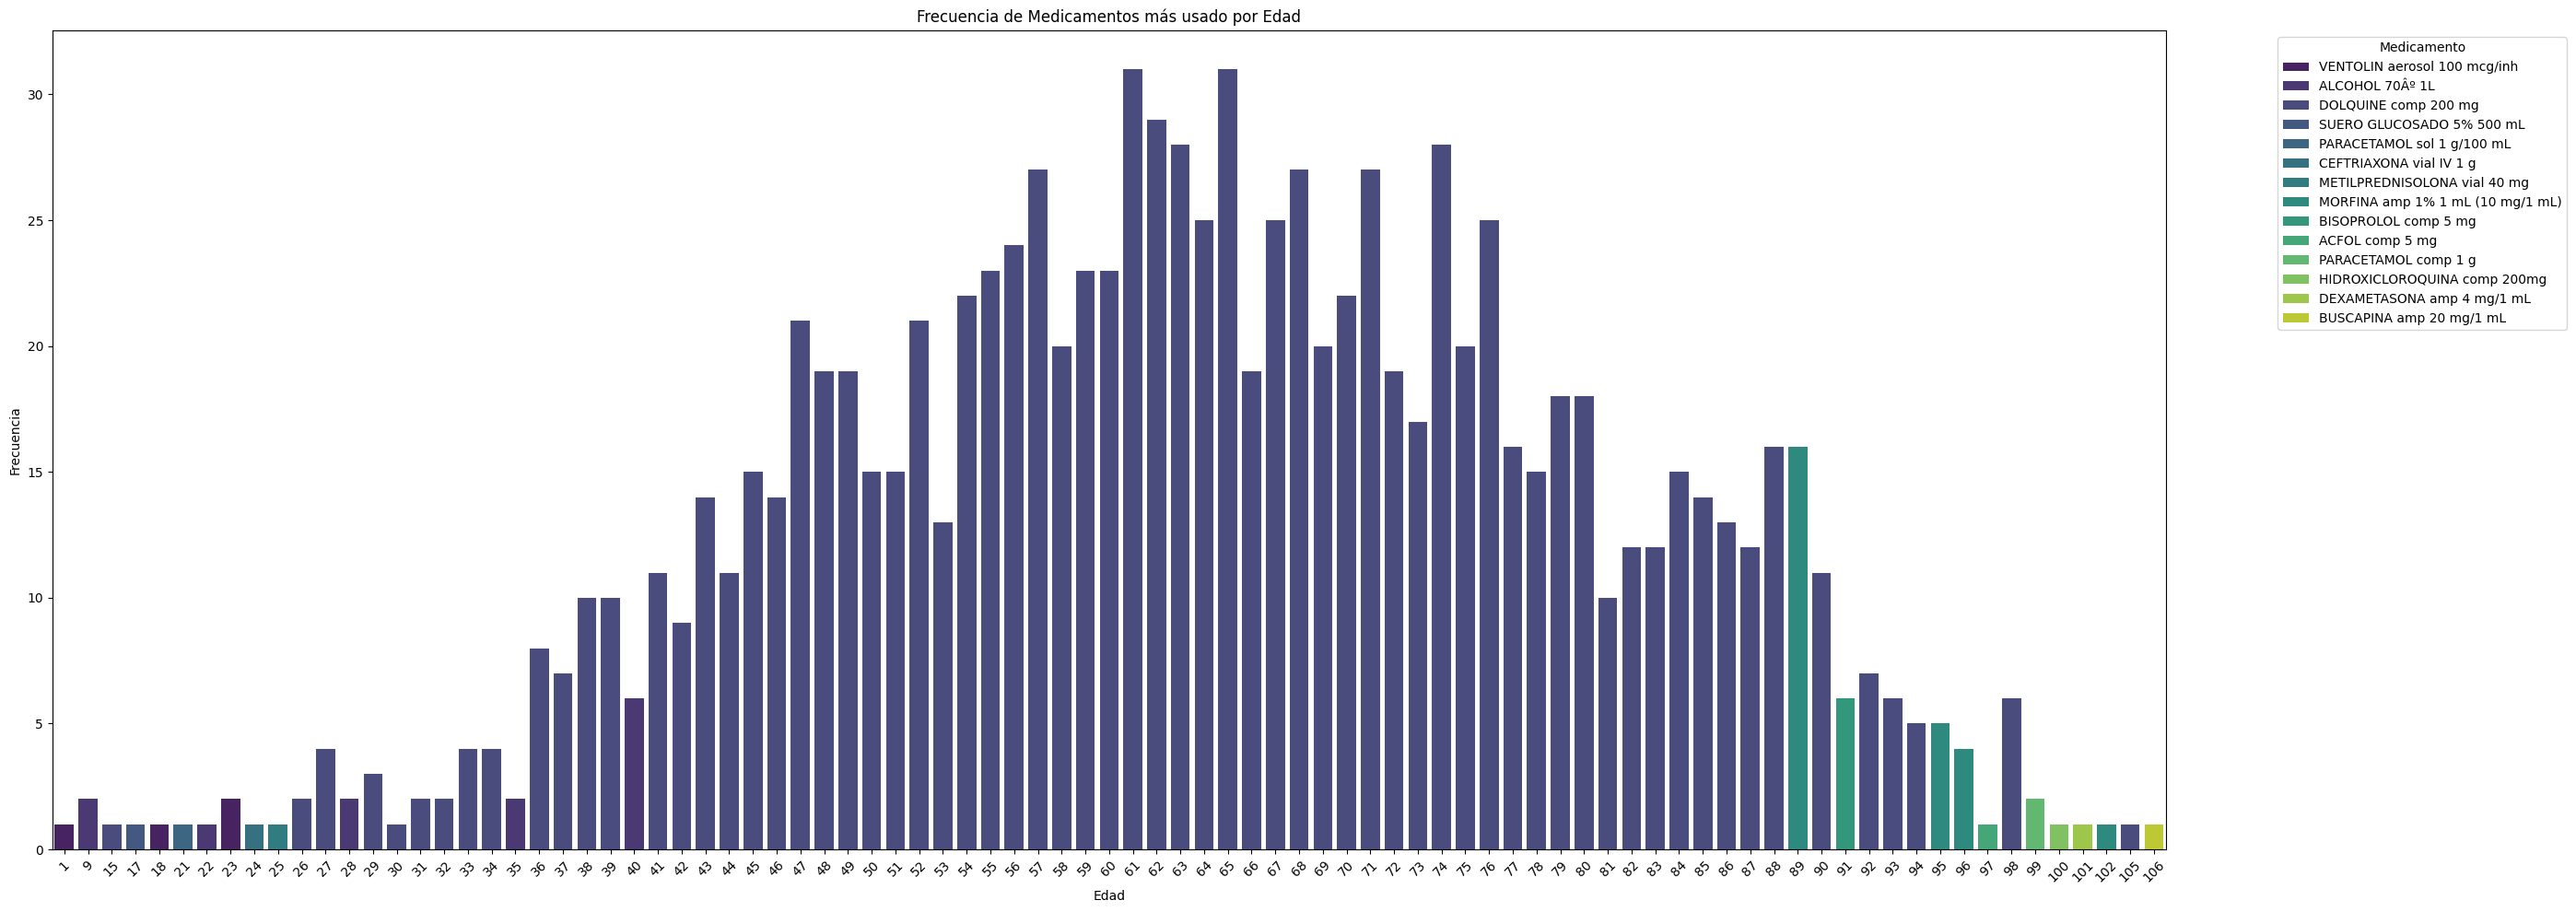

In [104]:
import seaborn as sns
print("Tabla de frecuencias de FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME por EDAD/AGE:")
plt.figure(figsize=(28, 10))  # Tamaño grande y manejable
ax = sns.barplot(x='EDAD/AGE', y='counts', hue='FARMACO/DRUG_NOMBRE_COMERCIAL/COMERCIAL_NAME', data=tabla_max, palette='viridis')
plt.title('Frecuencia de Medicamentos más usado por Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Medicamento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Evolución de las constantes

Métricas que no incluyen los casos de la UCI/ICU

In [105]:
df_const = df.copy()

In [106]:
# filtrado de columnas que contienen información de las constantes de los pacientes
df_const = df_const[['TA_MIN_ING/INPAT', 'CONSTANTS_ING/INPAT_HORA/TIME', 'GLU/GLY_ING/INPAT', 'CONSTANTS_ING/INPAT_FECHA/DATE', 'TEMP_ING/INPAT', 'FC/HR_ING/INPAT', 'TA_MAX_ING/INPAT', 'SAT_02_ING/INPAT', 'DIAG ING/INPAT']]
df_const = df_const[df_const['DIAG ING/INPAT'].str.contains('COVID19', na=False, case=False)]
# drop DIAG ING/INPAT column
df_const = df_const.drop(columns=['DIAG ING/INPAT'])


In [107]:
df_const.dtypes

TA_MIN_ING/INPAT                  float64
CONSTANTS_ING/INPAT_HORA/TIME      object
GLU/GLY_ING/INPAT                 float64
CONSTANTS_ING/INPAT_FECHA/DATE     object
TEMP_ING/INPAT                    float64
FC/HR_ING/INPAT                   float64
TA_MAX_ING/INPAT                  float64
SAT_02_ING/INPAT                  float64
dtype: object

In [108]:
df_const

TA_MIN_ING/INPAT CONSTANTS_ING/INPAT_HORA/TIME  GLU/GLY_ING/INPAT  \
0                 75.0                         15:37                0.0   
1                  0.0                         23:39                0.0   
2                 60.0                         12:42                0.0   
3                 75.0                         16:58                0.0   
4                  0.0                         00:35                0.0   
...                ...                           ...                ...   
3913              88.0                         15:35                0.0   
3914              89.0                         15:34                0.0   
3915               0.0                         17:27                0.0   
3918               0.0                         17:18                0.0   
3921               0.0                         17:28                0.0   

     CONSTANTS_ING/INPAT_FECHA/DATE  TEMP_ING/INPAT  FC/HR_ING/INPAT  \
0                        2020-12-11            35.9             60.0   
1                        2020-04-19            36.2             74.0   
2                        2020-03-22            35.8             85.0   
3                        2020-03-16            37.4             87.0   
4                        2020-03-29            37.9              0.0   
...                             ...             ...              ...   
3913                     2020-03-23            37.7             95.0   
3914                     2020-03-23            35.7             59.0   
3915                     2020-03-23            38.0              0.0   
3918                     2020-03-25            36.8             58.0   
3921                     2020-03-23            36.5              0.0   

      TA_MAX_ING/INPAT  SAT_02_ING/INPAT  
0                126.0               0.0  
1                  0.0               0.0  
2                120.0               0.0  
3                130.0               0.0  
4                  0.0               0.0  
...                ...               ...  
3913             142.0               0.0  
3914             130.0               0.0  
3915               0.0               0.0  
3918               0.0               0.0  
3921               0.0               0.0  

[3270 rows x 8 columns]

In [109]:
df_const.fillna(0, inplace=True)
# Convertir las columnas numéricas a tipo float
# Convertir las columnas a numéricas, forzando errores a NaN y luego rellenando con 0 antes de convertir a int/float
df_const['TA_MIN_ING/INPAT'] = pd.to_numeric(df_const['TA_MIN_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['GLU/GLY_ING/INPAT'] = pd.to_numeric(df_const['GLU/GLY_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['FC/HR_ING/INPAT'] = pd.to_numeric(df_const['FC/HR_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['TEMP_ING/INPAT'] = pd.to_numeric(df_const['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(float)
df_const['TA_MAX_ING/INPAT'] = pd.to_numeric(df_const['TA_MAX_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const['SAT_02_ING/INPAT'] = pd.to_numeric(df_const['SAT_02_ING/INPAT'], errors='coerce').fillna(0).astype(int)
# imputar los valores 0 por la media de la columna
df_const['TA_MIN_ING/INPAT'] = df_const['TA_MIN_ING/INPAT'].replace(0, round(df_const['TA_MIN_ING/INPAT'].mean()))
df_const['GLU/GLY_ING/INPAT'] = df_const['GLU/GLY_ING/INPAT'].replace(0, round((df_const['GLU/GLY_ING/INPAT'].mean())))
df_const['TEMP_ING/INPAT'] = df_const['TEMP_ING/INPAT'].replace(0, round(df_const['TEMP_ING/INPAT'].mean()))
df_const['FC/HR_ING/INPAT'] = df_const['FC/HR_ING/INPAT'].replace(0, round(df_const['FC/HR_ING/INPAT'].mean()))
df_const['SAT_02_ING/INPAT'] = df_const['SAT_02_ING/INPAT'].replace(0, round(df_const['SAT_02_ING/INPAT'].mean()))
df_const['TA_MAX_ING/INPAT'] = df_const['TA_MAX_ING/INPAT'].replace(0, round(df_const['TA_MAX_ING/INPAT'].mean()))

In [110]:
# agrupar por 'CONSTANTS_ING/INPAT_FECHA/DATE' y calcular la media de las constantes
df_const_grouped = df_const.groupby('CONSTANTS_ING/INPAT_FECHA/DATE').aggregate({
    'TA_MIN_ING/INPAT': 'mean',
    'TA_MAX_ING/INPAT': 'mean',
    'TEMP_ING/INPAT': 'mean',
    'FC/HR_ING/INPAT': 'mean',
    'SAT_02_ING/INPAT': 'mean',
    'GLU/GLY_ING/INPAT': 'mean'
}).reset_index()
df_const_grouped

CONSTANTS_ING/INPAT_FECHA/DATE  TA_MIN_ING/INPAT  TA_MAX_ING/INPAT  \
0                       2020-03-01             49.00             101.0   
1                       2020-03-03             60.00             110.0   
2                       2020-03-05             72.00             155.5   
3                       2020-03-06             37.00              64.0   
4                       2020-03-07             48.00             124.0   
..                             ...               ...               ...   
211                     2021-02-09             93.00             175.0   
212                     2021-02-10             37.00              64.0   
213                     2021-02-11             37.00              64.0   
214                     2021-02-12             41.75              77.5   
215                     2021-02-13             79.00             117.0   

     TEMP_ING/INPAT  FC/HR_ING/INPAT  SAT_02_ING/INPAT  GLU/GLY_ING/INPAT  
0         35.000000        77.000000          2.000000                0.0  
1         36.100000        57.000000          2.000000                0.0  
2         36.850000        73.500000          2.000000                0.0  
3         37.300000        63.666667          2.000000                0.0  
4         36.150000        70.000000          2.000000                0.0  
..              ...              ...               ...                ...  
211       36.300000        75.000000          2.000000                0.0  
212       35.283333        58.666667         79.333333                0.0  
213       35.000000        57.000000         95.250000                0.0  
214       35.200000        59.750000         71.250000                0.0  
215       36.300000        76.000000          2.000000                0.0  

[216 rows x 7 columns]

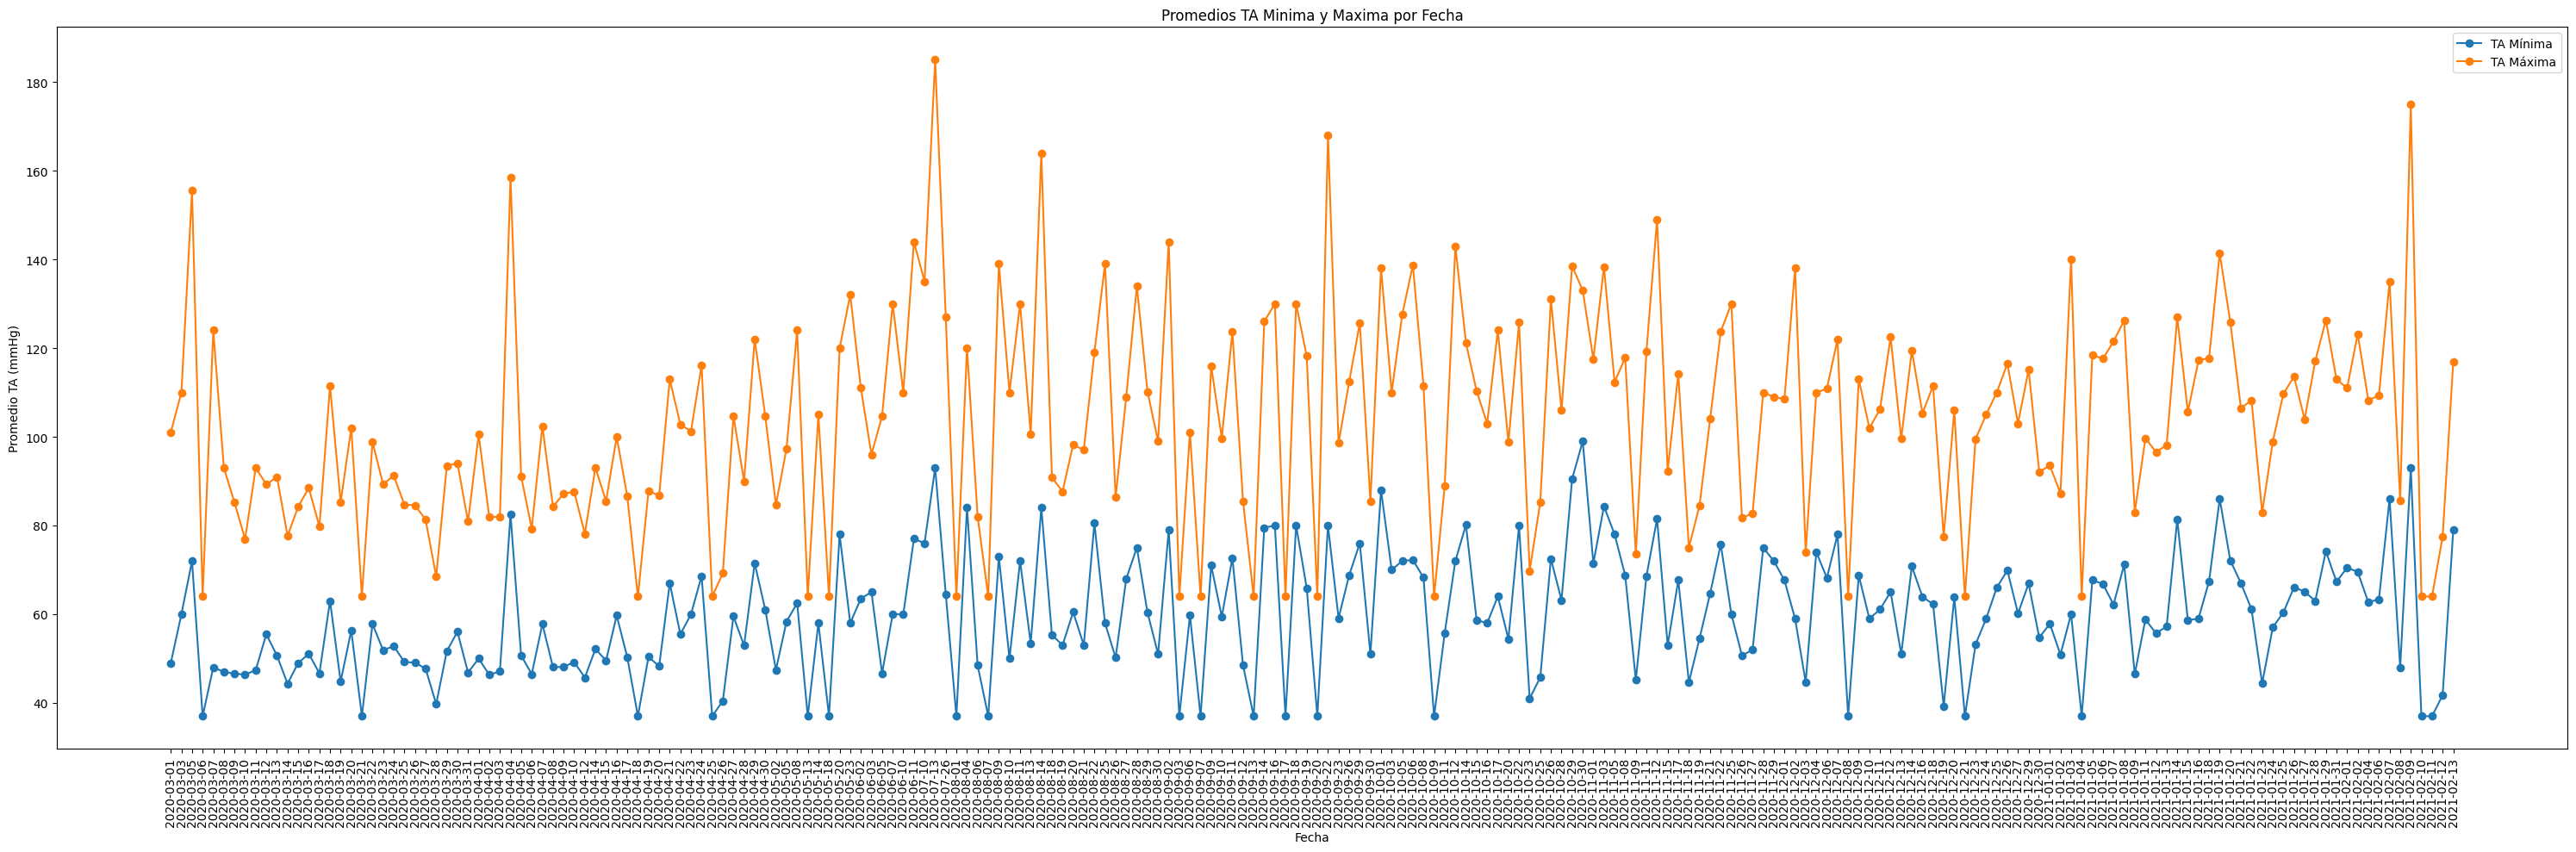

In [111]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['TA_MIN_ING/INPAT'], label='TA Mínima', marker='o')
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['TA_MAX_ING/INPAT'], label='TA Máxima', marker='o')
plt.title('Promedios TA Minima y Maxima por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Promedio TA (mmHg)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

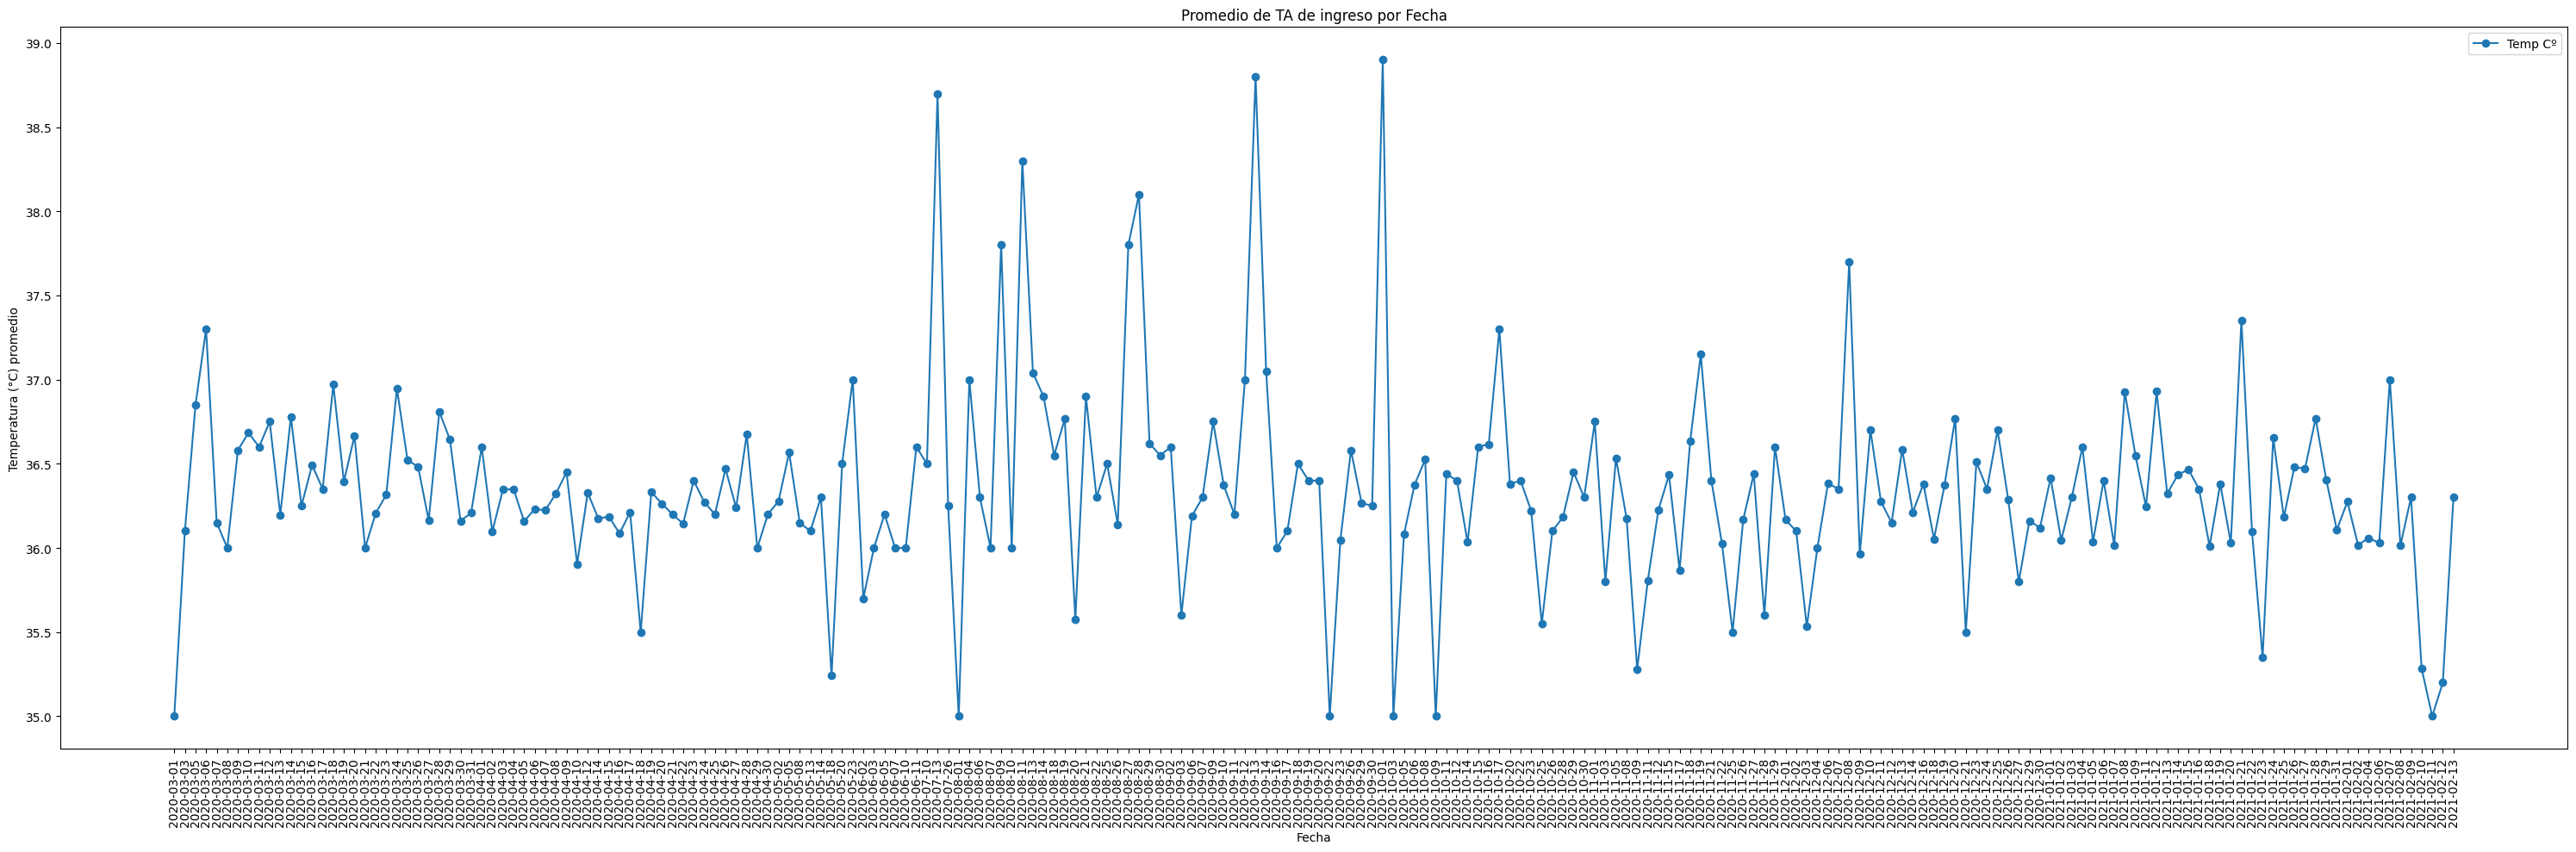

In [112]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['TEMP_ING/INPAT'], label='Temp Cº', marker='o')
plt.title('Promedio de TA de ingreso por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

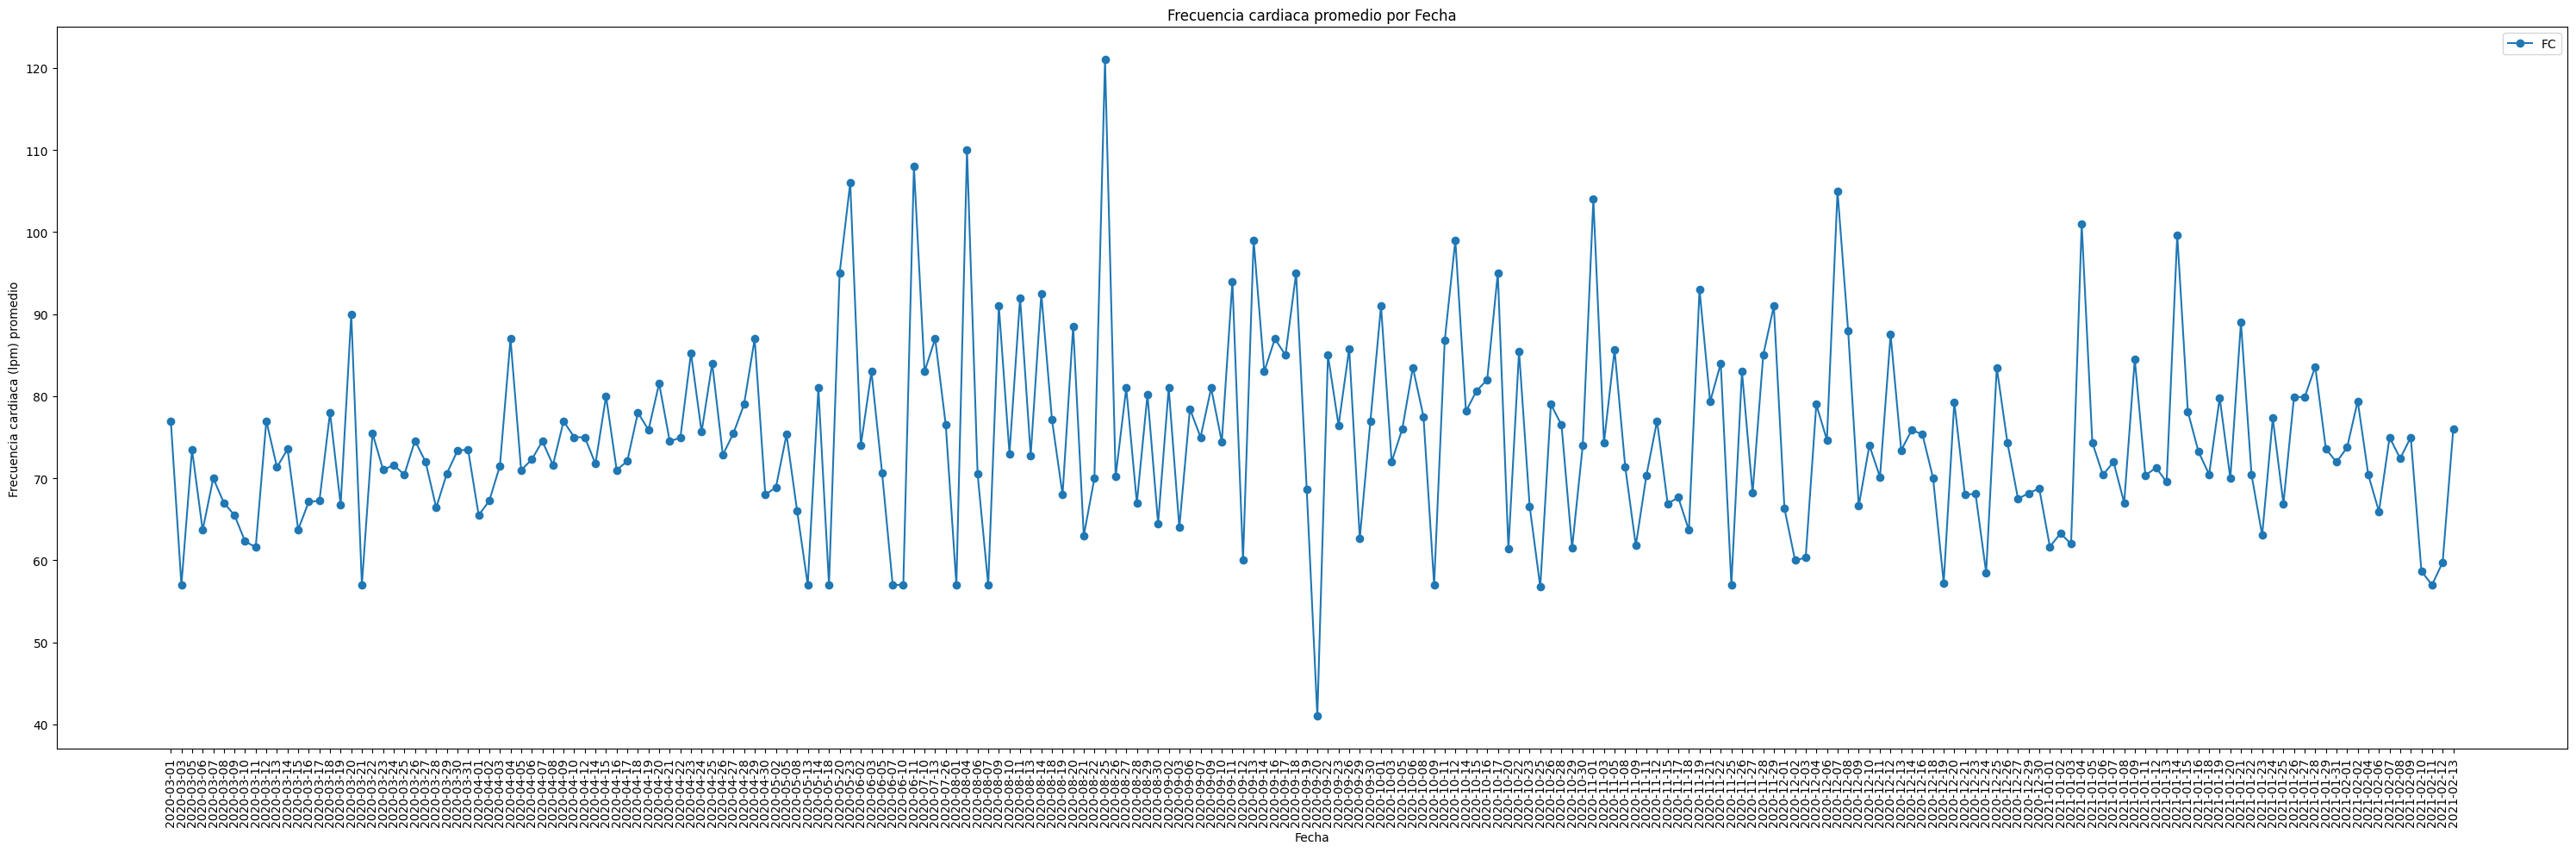

In [113]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['FC/HR_ING/INPAT'], label='FC', marker='o')
plt.title('Frecuencia cardiaca promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia cardiaca (lpm) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

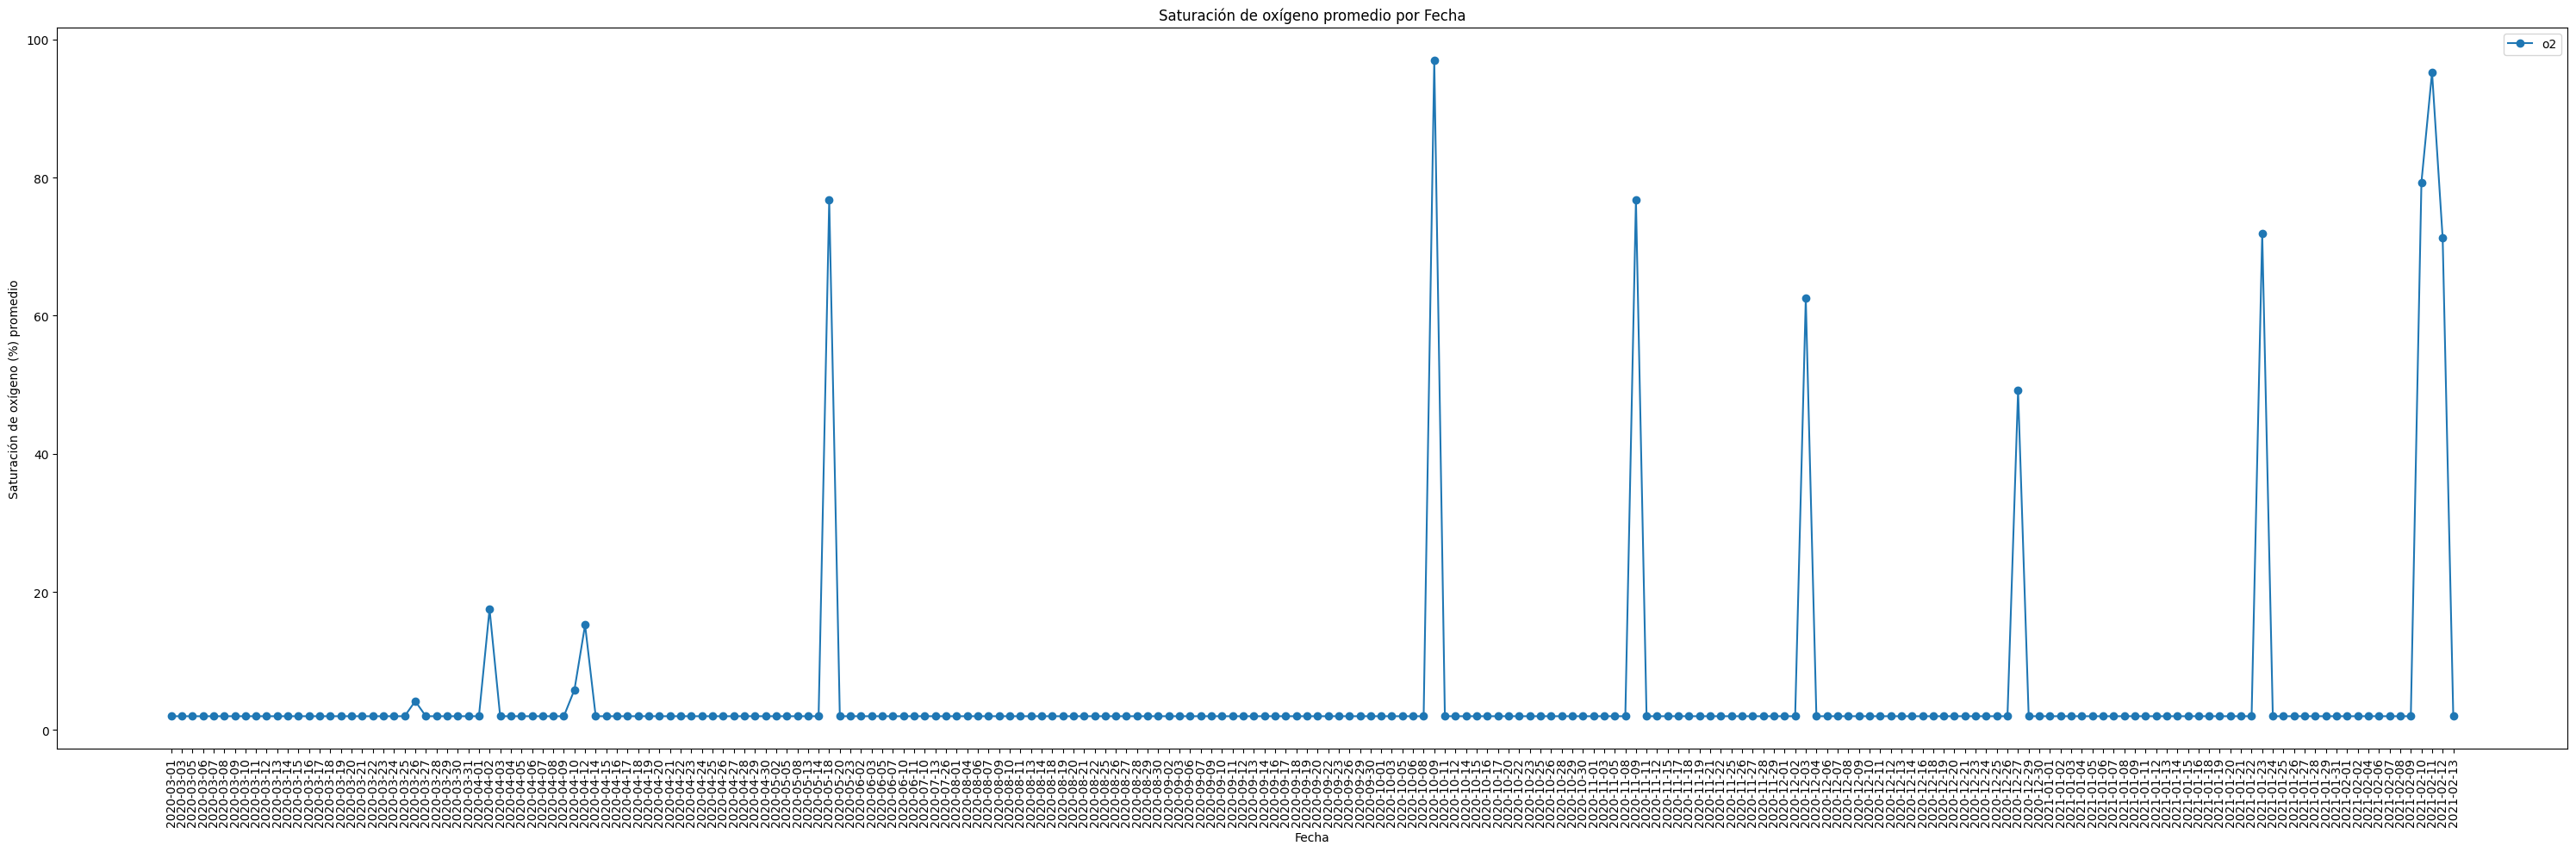

In [114]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['SAT_02_ING/INPAT'], label='o2', marker='o')
plt.title('Saturación de oxígeno promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Saturación de oxígeno (%) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


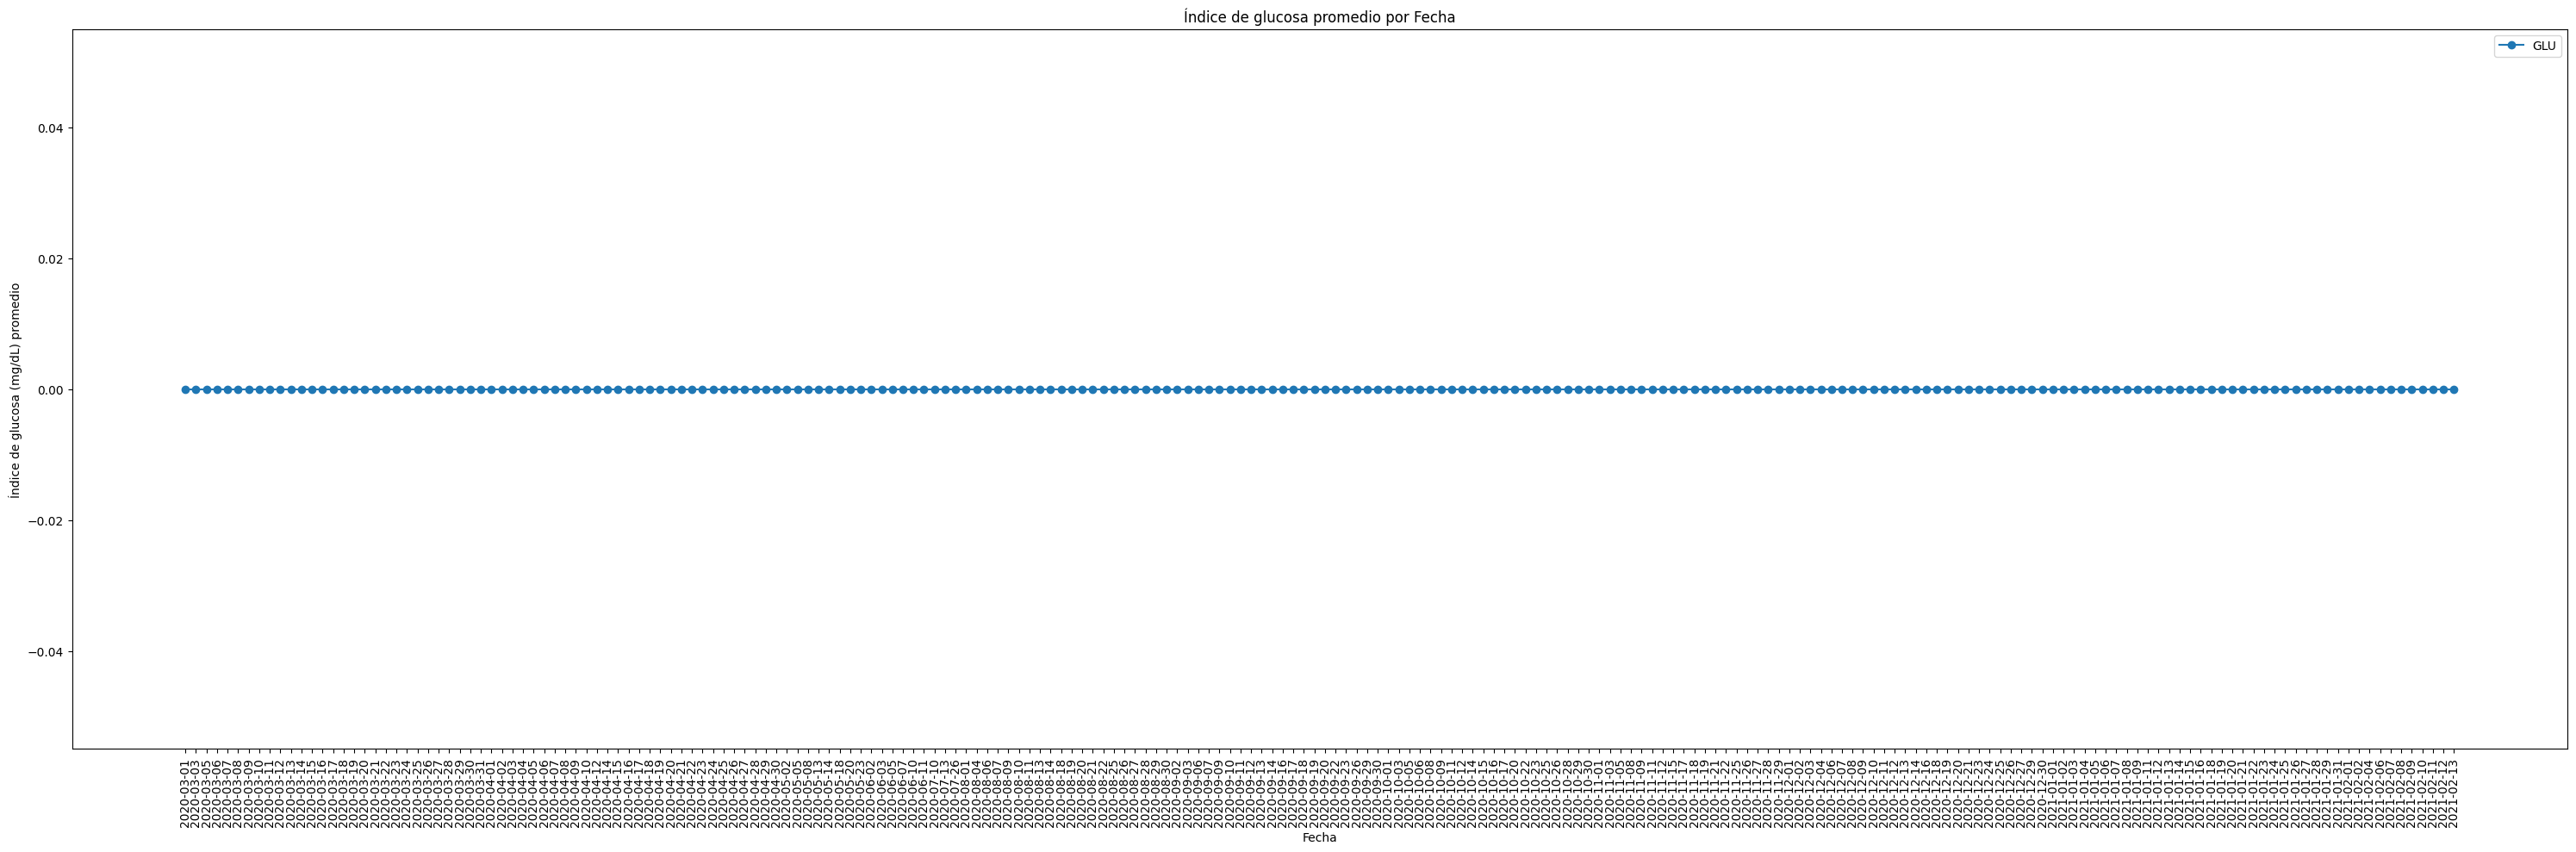

In [115]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_grouped['CONSTANTS_ING/INPAT_FECHA/DATE'], df_const_grouped['GLU/GLY_ING/INPAT'], label='GLU', marker='o')
plt.title('Índice de glucosa promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Índice de glucosa (mg/dL) promedio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


Métricas que se tomaron en urgencias y en UCI

In [116]:
df_const_uci = df[['TA_MIN_PRIMERA/FIRST_URG/EMERG',
                        'TA_MIN_ULTIMA/LAST_URG/EMERG',
                        'HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG',
                        'HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG',
                        'GLU_PRIMERA/FIRST_URG/EMERG',
                        'GLU_ULTIMA/LAST_URG/EMERG',
                        'TEMP_PRIMERA/FIRST_URG/EMERG',
                        'TEMP_ULTIMA/LAST_URG/EMERG',
                        'FC/HR_PRIMERA/FIRST_URG/EMERG',
                        'FC/HR_ULTIMA/LAST_URG/EMERG',
                        'TA_MAX_PRIMERA/FIRST/EMERG_URG',
                        'TA_MAX_ULTIMA/LAST_URGEMERG',
                        'SAT_02_PRIMERA/FIRST_URG/EMERG',
                        'SAT_02_ULTIMA/LAST_URG/EMERG',
                        'F_INGRESO/ADMISSION_D_ING/INPAT',
                        'DIAG ING/INPAT'
                        ]]

In [117]:
df_const_uci.dtypes

TA_MIN_PRIMERA/FIRST_URG/EMERG                float64
TA_MIN_ULTIMA/LAST_URG/EMERG                  float64
HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG     object
HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG       object
GLU_PRIMERA/FIRST_URG/EMERG                   float64
GLU_ULTIMA/LAST_URG/EMERG                     float64
TEMP_PRIMERA/FIRST_URG/EMERG                   object
TEMP_ULTIMA/LAST_URG/EMERG                     object
FC/HR_PRIMERA/FIRST_URG/EMERG                 float64
FC/HR_ULTIMA/LAST_URG/EMERG                   float64
TA_MAX_PRIMERA/FIRST/EMERG_URG                float64
TA_MAX_ULTIMA/LAST_URGEMERG                   float64
SAT_02_PRIMERA/FIRST_URG/EMERG                float64
SAT_02_ULTIMA/LAST_URG/EMERG                  float64
F_INGRESO/ADMISSION_D_ING/INPAT                object
DIAG ING/INPAT                                 object
dtype: object

In [118]:
df_const_uci

TA_MIN_PRIMERA/FIRST_URG/EMERG  TA_MIN_ULTIMA/LAST_URG/EMERG  \
0                                0.0                           0.0   
1                              101.0                         101.0   
2                               83.0                          83.0   
3                               82.0                          82.0   
4                               71.0                          71.0   
...                              ...                           ...   
3917                            88.0                          88.0   
3918                            73.0                          73.0   
3919                             0.0                           0.0   
3920                            72.0                          72.0   
3921                             0.0                           0.0   

     HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG  \
0                                      11:37:00   
1                                      18:27:00   
2                                      15:35:00   
3                                       0:41:00   
4                                       0:46:00   
...                                         ...   
3917                                      20:40   
3918                                      20:22   
3919                                      21:13   
3920                                      20:56   
3921                                      21:13   

     HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG  GLU_PRIMERA/FIRST_URG/EMERG  \
0                                    19:24:00                          0.0   
1                                    18:34:00                          0.0   
2                                    18:54:00                          0.0   
3                                     0:55:00                          0.0   
4                                     0:57:00                          0.0   
...                                       ...                          ...   
3917                                    20:42                          0.0   
3918                                    20:18                          0.0   
3919                                    22:12                          0.0   
3920                                    20:53                          0.0   
3921                                    22:13                          0.0   

      GLU_ULTIMA/LAST_URG/EMERG TEMP_PRIMERA/FIRST_URG/EMERG  \
0                           0.0                            0   
1                           0.0                            0   
2                           0.0                  37,09999847   
3                           0.0                           36   
4                           0.0                         37,8   
...                         ...                          ...   
3917                        0.0           37,799999999999997   
3918                        0.0           37,700000000000003   
3919                        0.0           37,299999999999997   
3920                        0.0           38,399999999999999   
3921                        0.0           36,799999999999997   

     TEMP_ULTIMA/LAST_URG/EMERG  FC/HR_PRIMERA/FIRST_URG/EMERG  \
0                             0                            0.0   
1                             0                          105.0   
2                            37                           92.0   
3                            36                           84.0   
4                   37,79999924                           80.0   
...                         ...                            ...   
3917         37,799999237060547                           85.0   
3918         37,700000762939453                           74.0   
3919         37,299999237060547                           82.0   
3920         38,400001525878906                          100.0   
3921         36,799999237060547                           89.0   

      FC/HR_ULTIMA/LAST_URG/EMERG  TA_MAX_PRIMERA/FIR

In [119]:
df_const_uci = df_const_uci[df_const_uci['DIAG ING/INPAT'].str.contains('COVID19', na=False, case=False)]
# drop DIAG ING/INPAT column
df_const_uci = df_const_uci.drop(columns=['DIAG ING/INPAT'])
df_const_uci.fillna(0, inplace=True)
# sustituir los valores , por . en las columnas TEMP_PRIMERA/FIRST_URG/EMERG	TEMP_ULTIMA/LAST_URG/EMERG
df_const_uci.loc[:, 'TEMP_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['TEMP_PRIMERA/FIRST_URG/EMERG'].str.replace(',', '.')
df_const_uci.loc[:, 'TEMP_ULTIMA/LAST_URG/EMERG'] = df_const_uci['TEMP_ULTIMA/LAST_URG/EMERG'].str.replace(',', '.')
# transformar TEMP_PRIMERA/FIRST_URG/EMERG	TEMP_ULTIMA/LAST_URG/EMERG de string a float con dos decimales
df_const_uci.loc[:, 'TEMP_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['TEMP_PRIMERA/FIRST_URG/EMERG'].astype(float).round(2)
df_const_uci.loc[:, 'TEMP_ULTIMA/LAST_URG/EMERG'] = df_const_uci['TEMP_ULTIMA/LAST_URG/EMERG'].astype(float).round(2)
# Convertir las columnas a numéricas, forzando errores a NaN y luego rellenando con 0 antes de convertir a int/float

df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['TA_MIN_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['GLU/GLY_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['FC/HR_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['TA_MIN_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['GLU/GLY_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'] = pd.to_numeric(df_const['FC/HR_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'] = pd.to_numeric(df_const['TEMP_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'] = pd.to_numeric(df_const['TA_MAX_ING/INPAT'], errors='coerce').fillna(0).astype(int)
df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'] = pd.to_numeric(df_const['SAT_02_ING/INPAT'], errors='coerce').fillna(0).astype(int)

# imputar los valores 0 por la media de la columna
df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['TA_MIN_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'] = df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['TA_MIN_ULTIMA/LAST_URG/EMERG'].mean()))
df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['GLU_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'] = df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['GLU_ULTIMA/LAST_URG/EMERG'].mean()))
df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['FC/HR_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'] = df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['FC/HR_ULTIMA/LAST_URG/EMERG'].mean()))
df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'] = df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'].replace(0, round(df_const_uci['TA_MAX_PRIMERA/FIRST/EMERG_URG'].mean()))
df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'] = df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'].replace(0, round(df_const_uci['TA_MAX_ULTIMA/LAST_URGEMERG'].mean()))
df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'] = df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'].replace(0, round(df_const_uci['SAT_02_PRIMERA/FIRST_URG/EMERG'].mean()))
df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'] = df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'].replace(0, round(df_const_uci['SAT_02_ULTIMA/LAST_URG/EMERG'].mean()))

In [120]:
# agrupar por 'CONSTANTS_ING/INPAT_FECHA/DATE' y calcular la media de las constantes
df_const_uci_grouped = df_const_uci.groupby('F_INGRESO/ADMISSION_D_ING/INPAT').aggregate({
    'TA_MIN_PRIMERA/FIRST_URG/EMERG': 'mean',
    'TA_MAX_PRIMERA/FIRST/EMERG_URG': 'mean',
    'GLU_PRIMERA/FIRST_URG/EMERG': 'mean',
    'TEMP_PRIMERA/FIRST_URG/EMERG': 'mean',
    'FC/HR_PRIMERA/FIRST_URG/EMERG': 'mean',
    'SAT_02_PRIMERA/FIRST_URG/EMERG': 'mean',
    'TA_MIN_ULTIMA/LAST_URG/EMERG': 'mean',
    'TA_MAX_ULTIMA/LAST_URGEMERG': 'mean',
    'GLU_ULTIMA/LAST_URG/EMERG': 'mean',
    'TEMP_ULTIMA/LAST_URG/EMERG': 'mean',
    'FC/HR_ULTIMA/LAST_URG/EMERG': 'mean',
    'SAT_02_ULTIMA/LAST_URG/EMERG': 'mean'
    }).reset_index()

In [121]:
df_const_uci_grouped


F_INGRESO/ADMISSION_D_ING/INPAT  TA_MIN_PRIMERA/FIRST_URG/EMERG  \
0               01-04-2020 00:00:00                       84.000000   
1               01-05-2020 00:00:00                       68.333333   
2                        01/03/2020                       57.000000   
3                        01/04/2020                       53.020833   
4               02-05-2020 00:00:00                       68.500000   
..                              ...                             ...   
247                      29/03/2020                       56.555556   
248             30-03-2020 00:00:00                       90.000000   
249             30-04-2020 00:00:00                       73.000000   
250                      30/03/2020                       51.663043   
251                      31/03/2020                       60.820896   

     TA_MAX_PRIMERA/FIRST/EMERG_URG  GLU_PRIMERA/FIRST_URG/EMERG  \
0                         93.000000                    93.000000   
1                         82.000000                    82.000000   
2                         77.000000                    77.000000   
3                         71.583333                    71.583333   
4                         63.500000                    63.500000   
..                              ...                          ...   
247                       71.796296                    71.796296   
248                       86.000000                    86.000000   
249                       83.000000                    83.000000   
250                       68.380435                    68.380435   
251                       73.447761                    73.447761   

    TEMP_PRIMERA/FIRST_URG/EMERG  FC/HR_PRIMERA/FIRST_URG/EMERG  \
0                           35.4                      84.000000   
1                           30.4                      68.333333   
2                           35.6                      57.000000   
3                      27.402083                      53.020833   
4                          36.25                      68.500000   
..                           ...                            ...   
247                    30.544444                      56.555556   
248                         37.7                      90.000000   
249                         37.4                      73.000000   
250                    27.933696                      51.663043   
251                    31.213433                      60.820896   

     SAT_02_PRIMERA/FIRST_URG/EMERG  TA_MIN_ULTIMA/LAST_URG/EMERG  \
0                        125.000000                           0.0   
1                        107.333333                           0.0   
2                         93.000000                           0.0   
3                         93.041667                           0.0   
4                        102.000000                           0.0   
..                              ...                           ...   
247                       98.481481                           0.0   
248                      131.000000                           0.0   
249                      119.333333                           0.0   
250                       90.293478                           0.0   
251                      106.268657                           0.0   

     TA_MAX_ULTIMA/LAST_URGEMERG  GLU_ULTIMA/LAST_URG/EMERG  \
0                      36.000000                  36.000000   
1                      36.000000                  36.000000   
2                      36.000000                  36.000000   
3                      35.687500                  35.687500   
4                      36.000000                  36.000000   
..                           ...                        ...   
247                    35.722222                  35.722222   
248                    36.000000                  36.000000   
249                    35.666667                  35.666667   
250                    35.847826                  35.847826   
251    

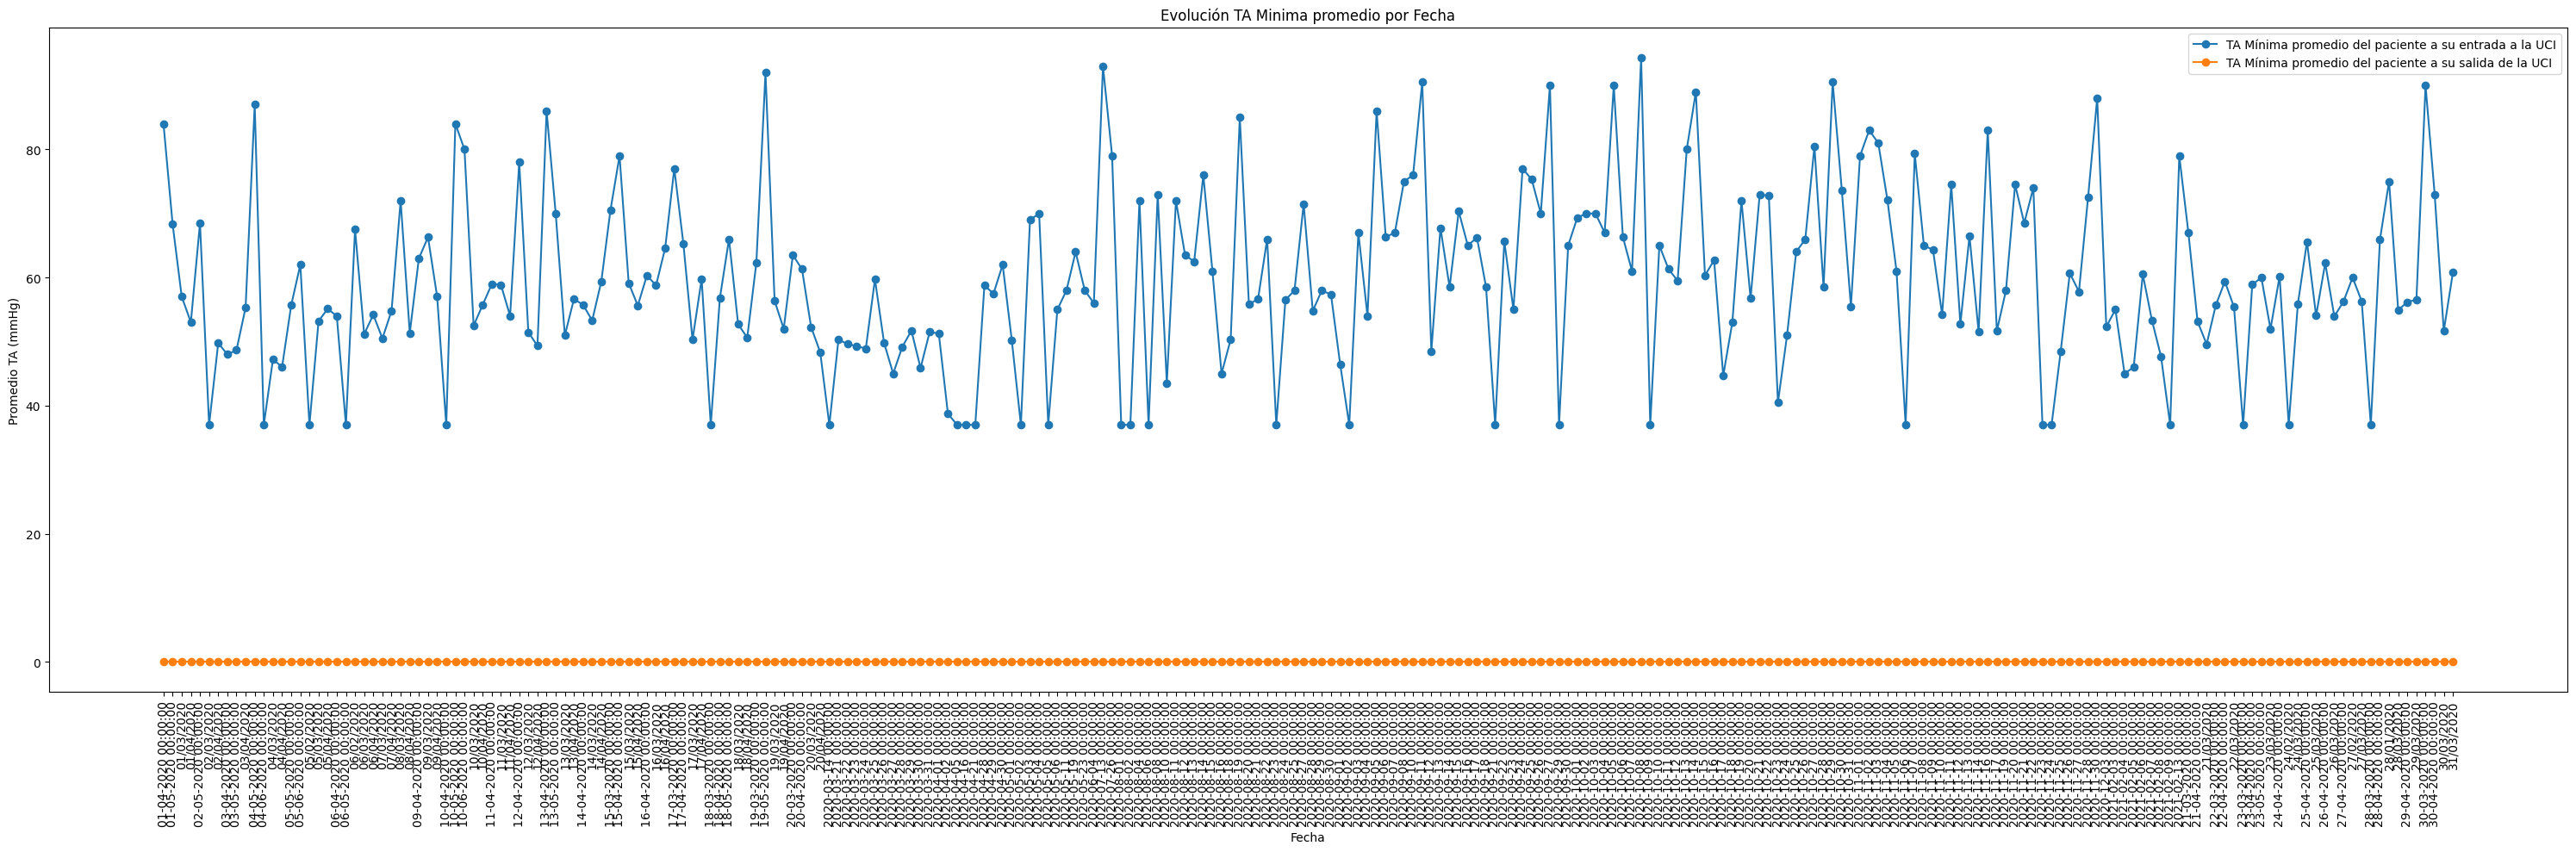

In [122]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MIN_PRIMERA/FIRST_URG/EMERG'], label='TA Mínima promedio del paciente a su entrada a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MIN_ULTIMA/LAST_URG/EMERG'], label='TA Mínima promedio del paciente a su salida de la UCI', marker='o')
plt.title('Evolución TA Minima promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Promedio TA (mmHg)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

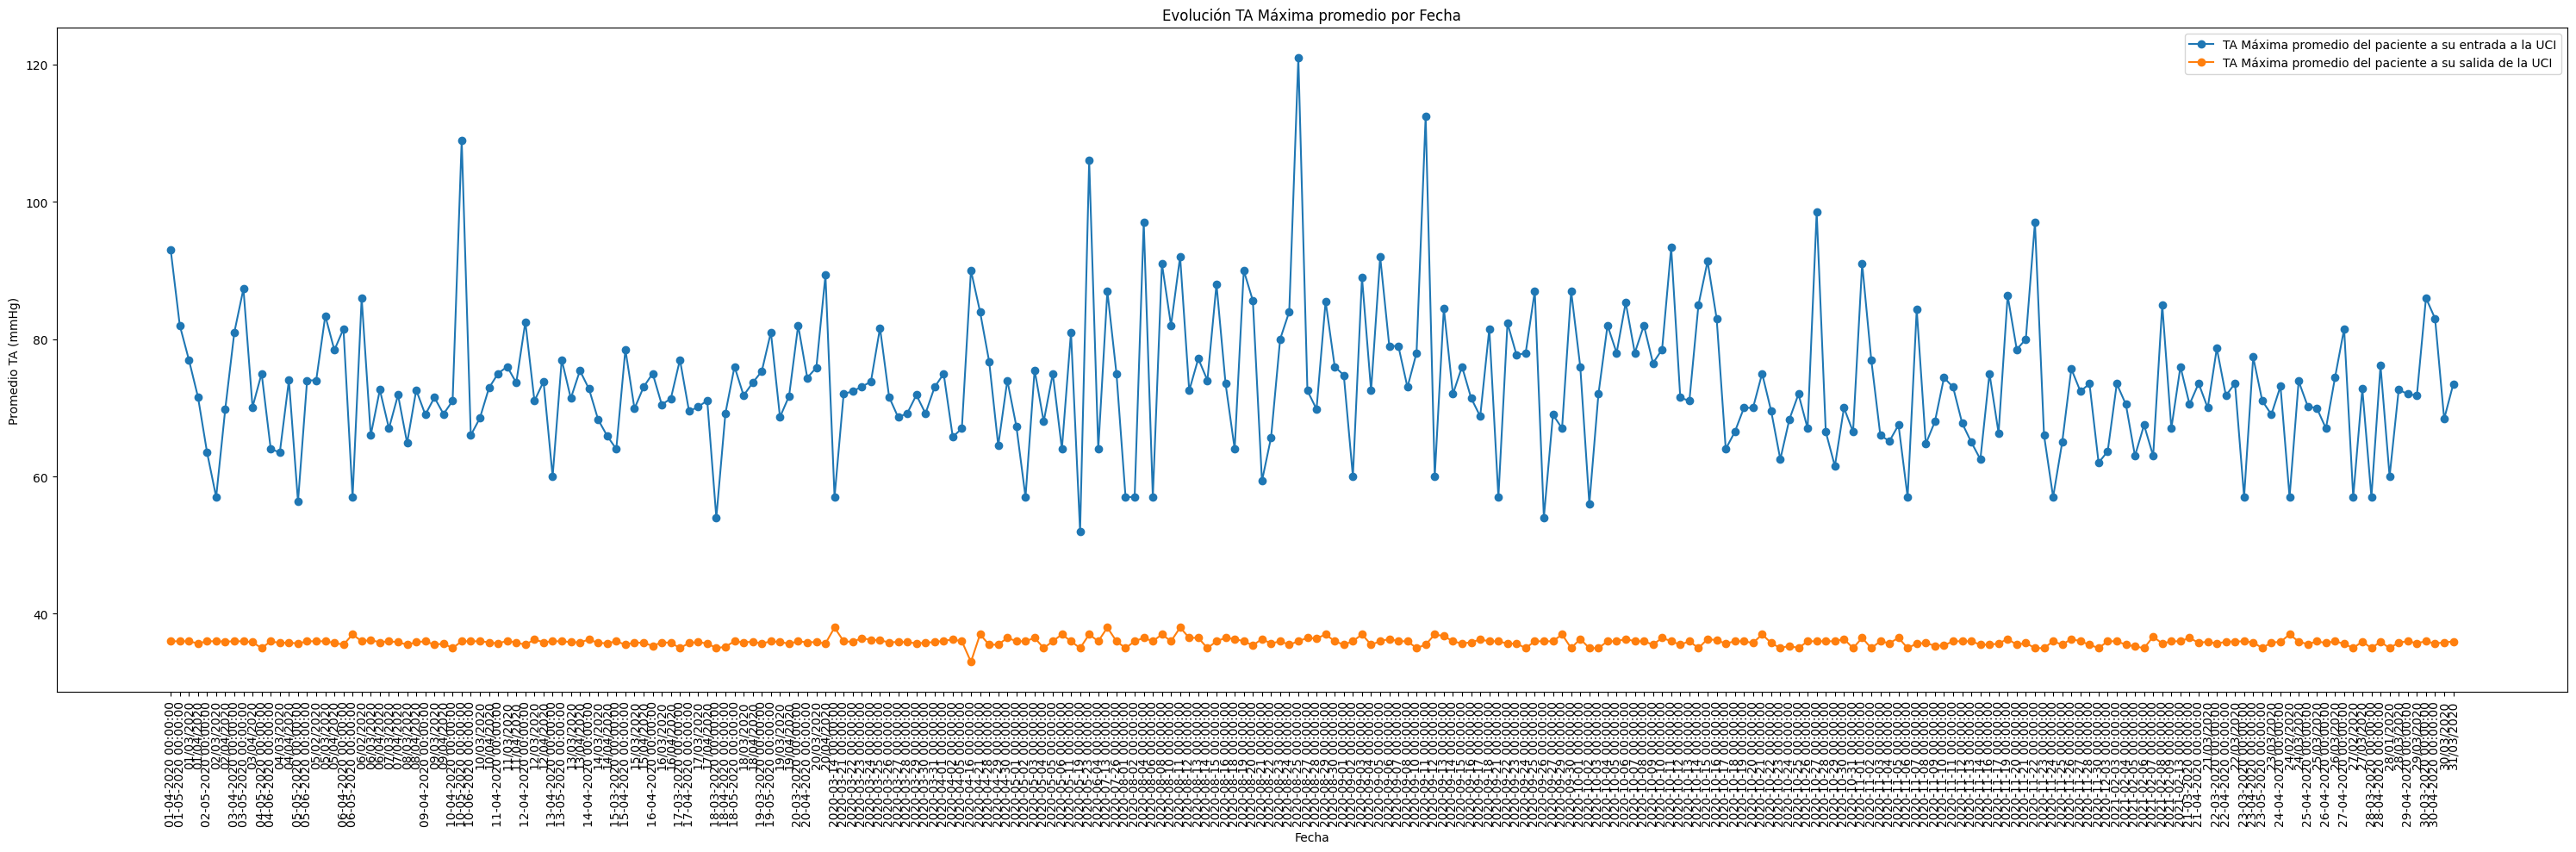

In [123]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MAX_PRIMERA/FIRST/EMERG_URG'], label='TA Máxima promedio del paciente a su entrada a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TA_MAX_ULTIMA/LAST_URGEMERG'], label='TA Máxima promedio del paciente a su salida de la UCI', marker='o')
plt.title('Evolución TA Máxima promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Promedio TA (mmHg)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

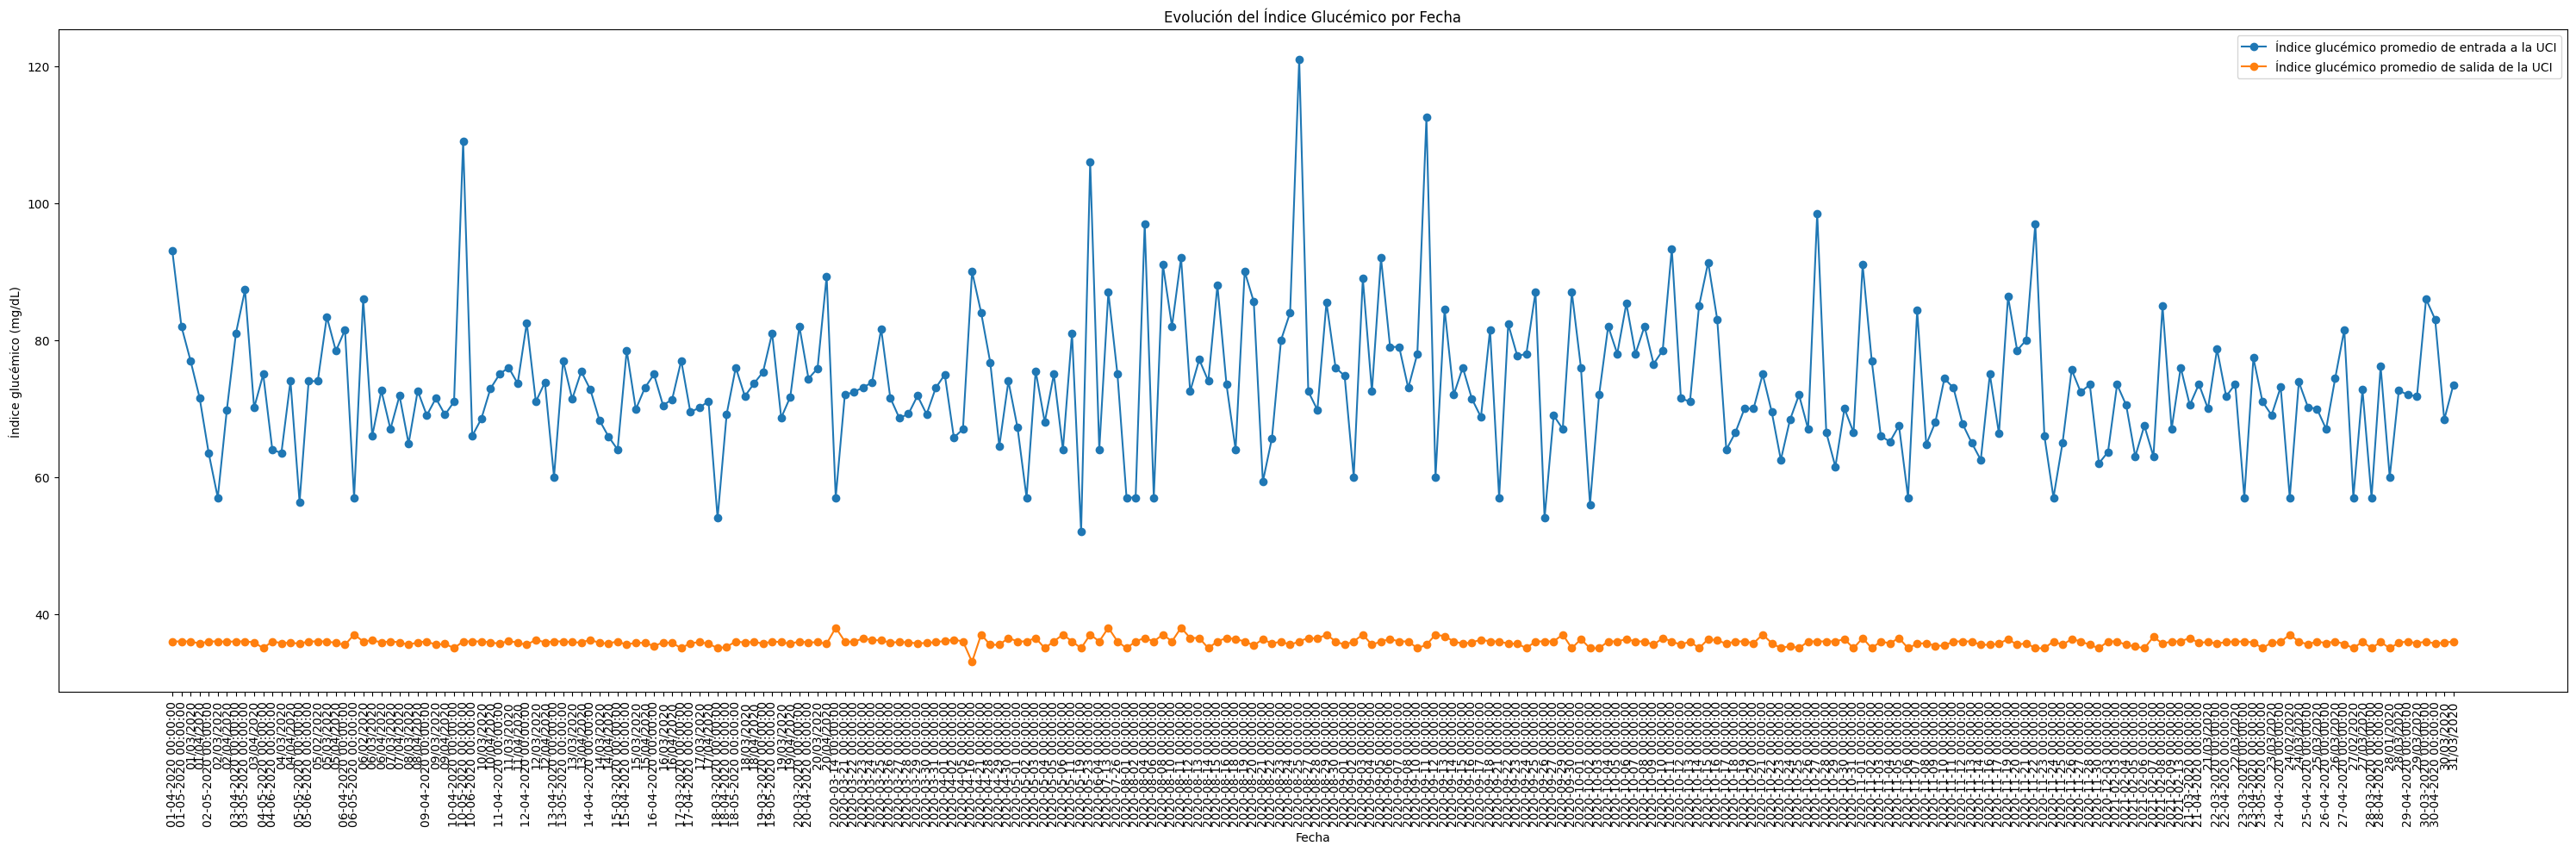

In [124]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['GLU_PRIMERA/FIRST_URG/EMERG'], label='Índice glucémico promedio de entrada a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['GLU_ULTIMA/LAST_URG/EMERG'], label='Índice glucémico promedio de salida de la UCI', marker='o')
plt.title('Evolución del Índice Glucémico por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Índice glucémico (mg/dL)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

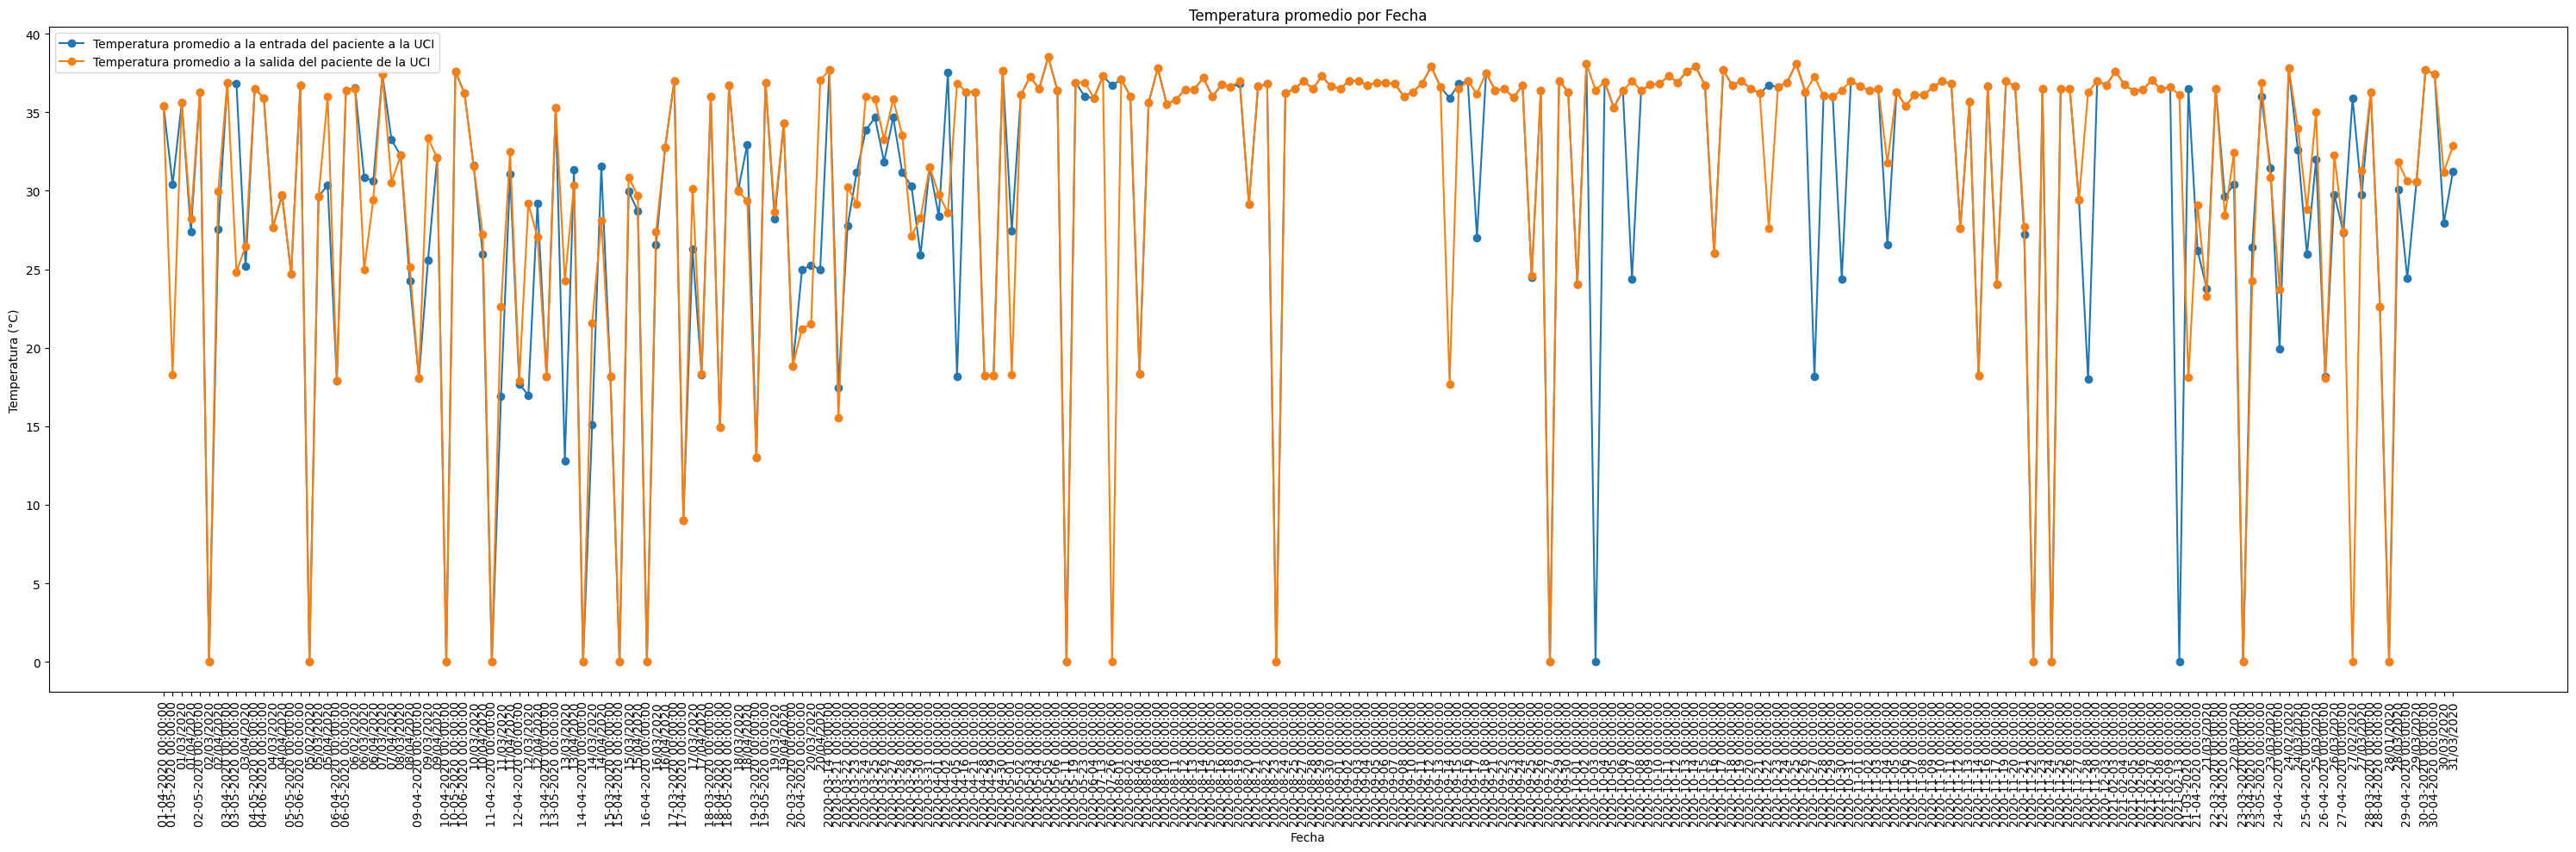

In [125]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TEMP_PRIMERA/FIRST_URG/EMERG'], label='Temperatura promedio a la entrada del paciente a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['TEMP_ULTIMA/LAST_URG/EMERG'], label='Temperatura promedio a la salida del paciente de la UCI', marker='o')
plt.title('Temperatura promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

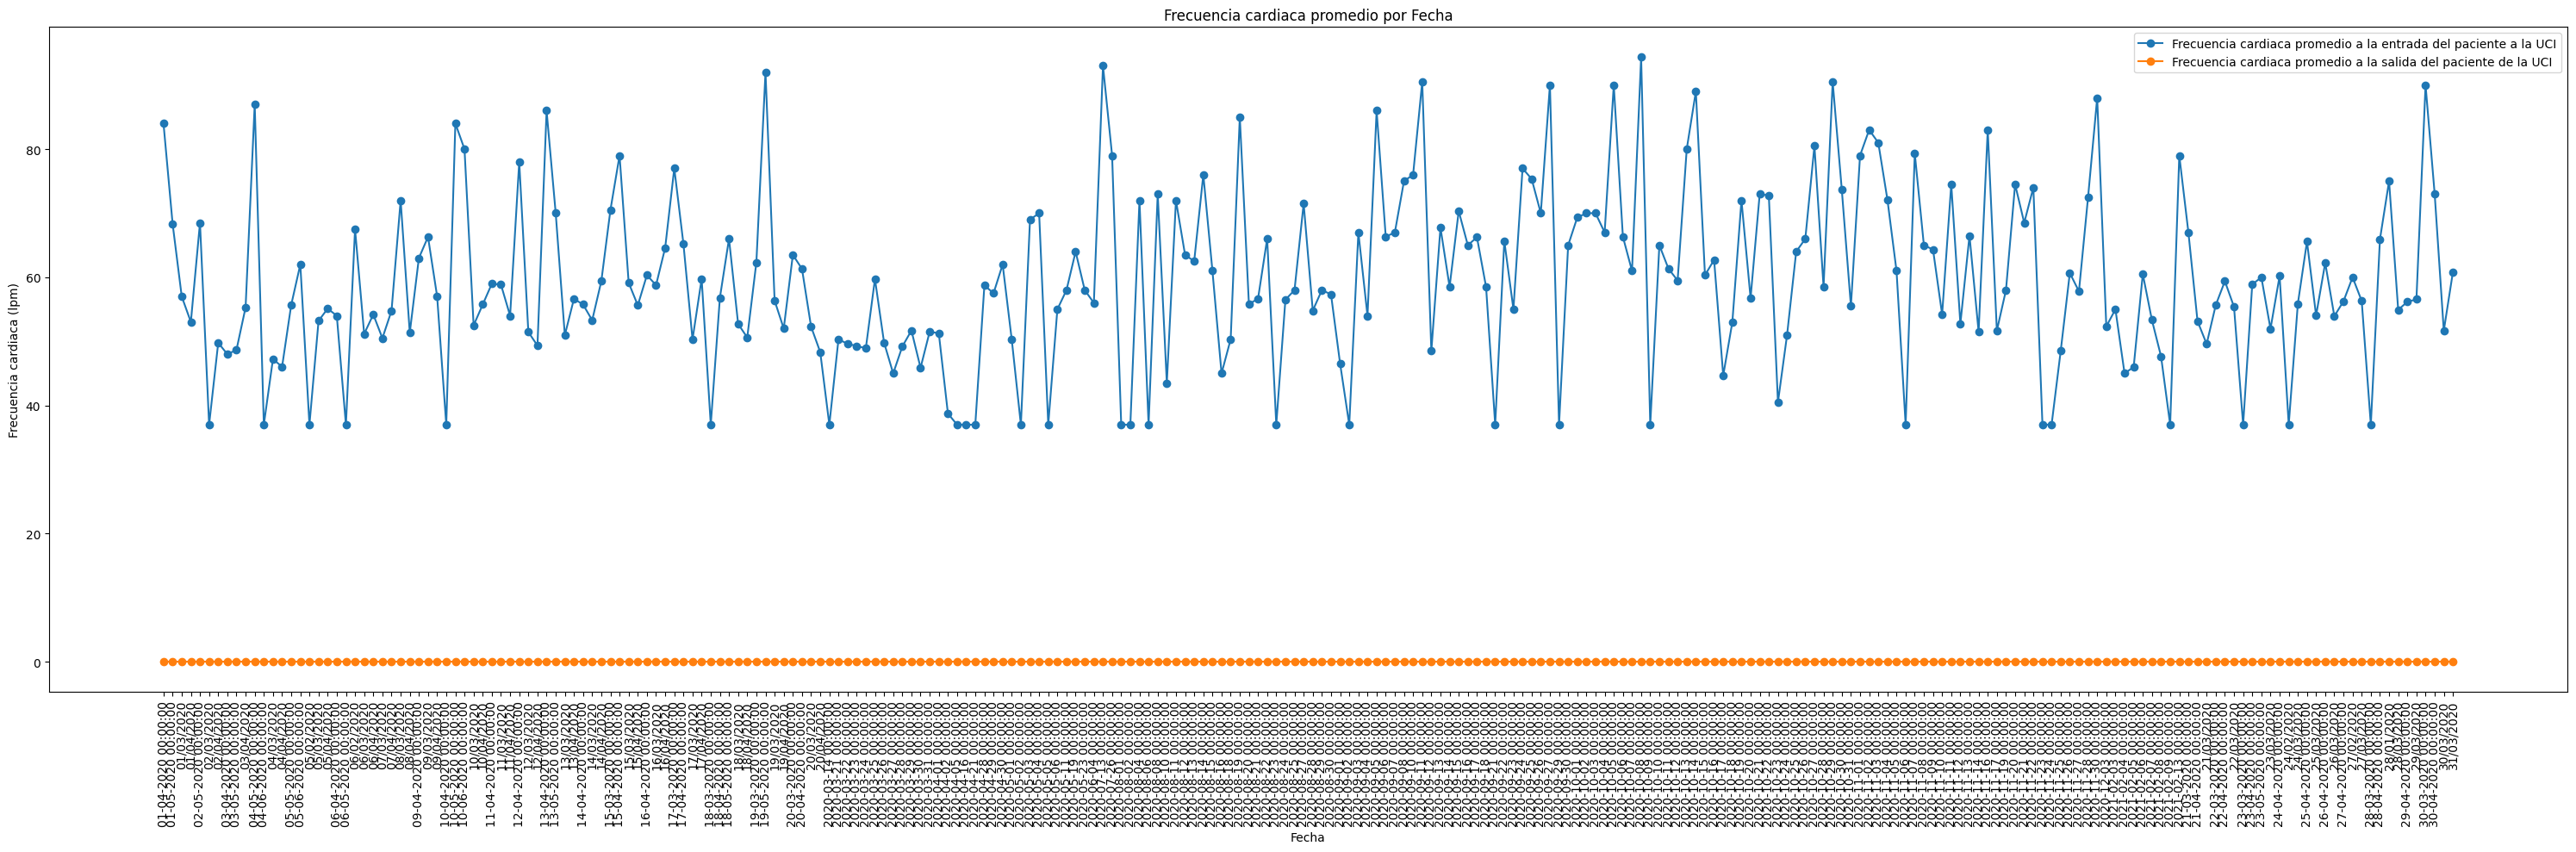

In [126]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['FC/HR_PRIMERA/FIRST_URG/EMERG'], label='Frecuencia cardiaca promedio a la entrada del paciente a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['FC/HR_ULTIMA/LAST_URG/EMERG'], label='Frecuencia cardiaca promedio a la salida del paciente de la UCI', marker='o')
plt.title('Frecuencia cardiaca promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia cardiaca (lpm)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

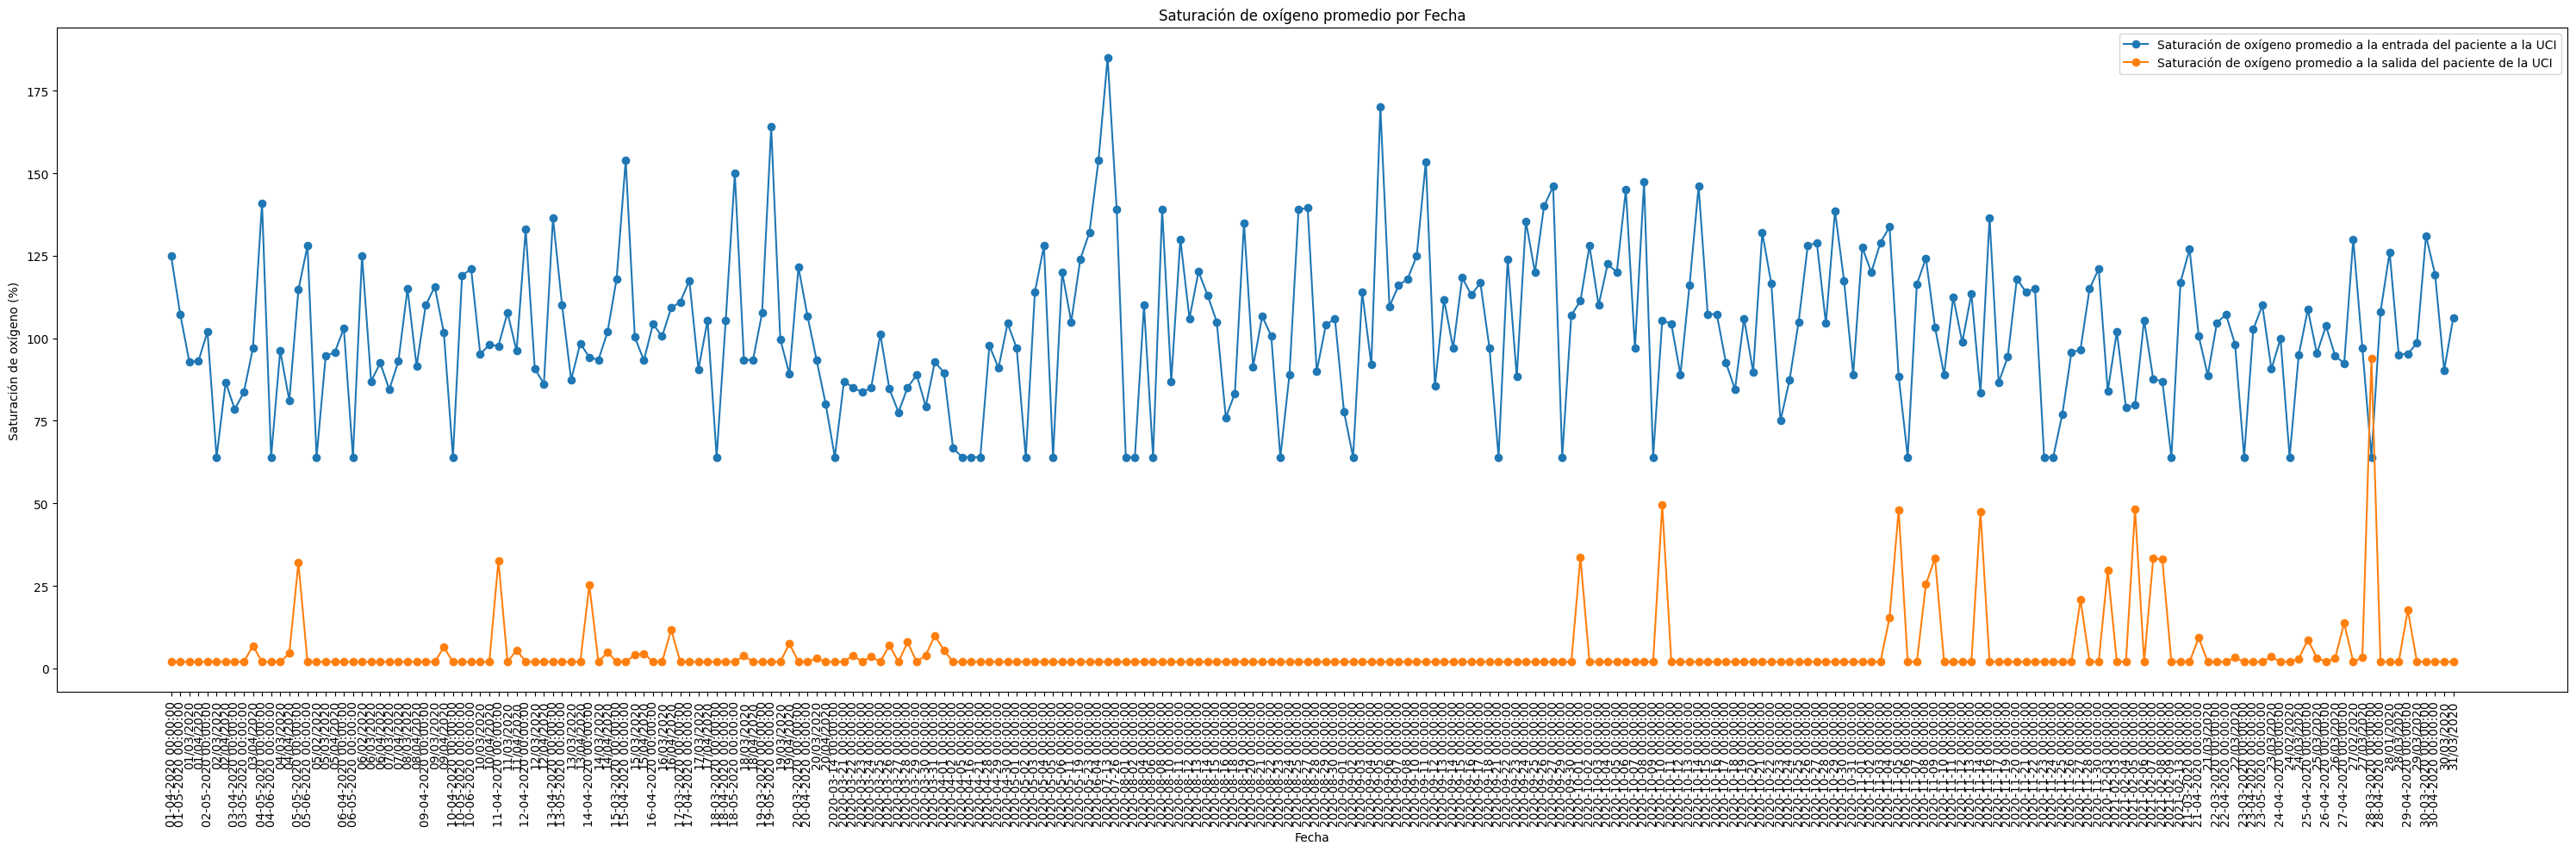

In [127]:
plt.figure(figsize=(30, 10))
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['SAT_02_PRIMERA/FIRST_URG/EMERG'], label='Saturación de oxígeno promedio a la entrada del paciente a la UCI', marker='o')
plt.plot(df_const_uci_grouped['F_INGRESO/ADMISSION_D_ING/INPAT'], df_const_uci_grouped['SAT_02_ULTIMA/LAST_URG/EMERG'], label='Saturación de oxígeno promedio a la salida del paciente de la UCI', marker='o')
plt.title('Saturación de oxígeno promedio por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Saturación de oxígeno (%)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()